# **Final Project Part 2**


## Group Members
- Samuel Ochs (Team Lead)
- Sarthak Tyagi
- Nainesh Rathod

## Contributions
- Sarthak's Contribution:
	- Data Visualization
		- Added a line plot indicating pollutants levels (pm2_5 and pm10)
		  over time
		- Violinplot of pm10 pollutant levels based on part of the day which reveals
		  interesting characterstics of increse in concentration around evening time of the day
		- Striplot showing CO pollutant levels based on part of the days revelas similar trends to the above plot.
	- Decomposition
		- Multiplicative and Additive Decomposition of the time series (It seems to be additive as the magnitude of seasonality remains constant and   multiplicative shows no pattern)
		- Partial Autocorrelation and autocorrelation plots for looking at significant lags of the data.
	- Models
		- I developed three time series models, A naive drift model and naive mean model for benchmarking on our data and a more advanced deep learning based model called nbeats. I plotted graphs of the test set predictions of the data and also benchmared my model on metrics like mape(mean avaerage precision error) and rmse(root mean squared error).
	- Total Time
		- 10 to 12 hrs

- Sam's Contribution:
	- Data Visualization
		- Added a horizontal bar chart to show monthly average of PM 2.5. The data had to be resampled from an hourly basis to a monthly basis.
		- There was an interesting insight from the graph, you could immediately observe some seasonality from the graph.
	- Decomposition
		- The seasonal variations were fairly consistent over time so an additive decompostion was used.
		- There are also periods of short term trends when the data was transitioning from season to season.
	- Models
		- I tested building ARIMA and SARIMAX models. Ultimately I ended up using a SARIMAX model due to the seasonality in the data. In order to generate the forecasts I created a walk forward forecast. I then plotted the test values against the prediction values. I benchedmarked the model with RMSE(root mean squared error) and MAPE(mean absolute percentage error).
	- Total Time
		- 5 - 7 hrs

- Nainesh's Contribution:
	- Data visualization: Analyzing the data and observing the data population.
	- Decomposition: Visually observing seasonality, trends and inferencing each pollutant attribute through graphs and plots.
	- Models:
		- Build a SARIMA model according to the seasonality and trends in the data. And performed forecasting for various attributes.
	- Total time:
		- 6-8 hours

## Samuel's Contribution

### Visualization plot, SARIMAX model training and evaluation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt

DATA_NEW="../data/delhi_aqi_new.csv" # change with your path
DATA_OLD="../data/delhi_aqi.csv" # change with your path

df = pd.read_csv(DATA_NEW)
df_work = df.copy()
df_work['date']=pd.to_datetime(arg=df_work['date'],format="%Y-%m-%d %H:%M:%S")
df_work.set_index('date',inplace=True)
df_work = df_work.resample('D').agg({
    'pm10': 'mean',
    'nh3': 'mean',
    'pm2_5': 'mean',
    'co': 'mean',
    'no': 'mean',
    'no2': 'mean',
    'o3': 'mean',
    'so2': 'mean'
})
df_work.interpolate(method='linear', inplace=True)

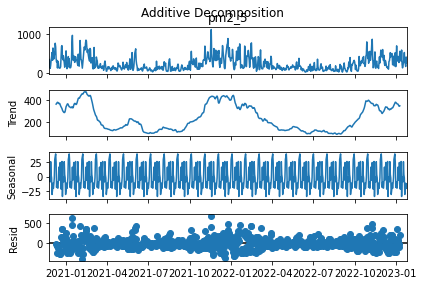

In [ ]:
# 1.Time series decomposition
adec=seasonal_decompose(df_work['pm2_5'],model='additive',period=30)
adec.plot()
plt.suptitle('Additive Decomposition')
plt.show()

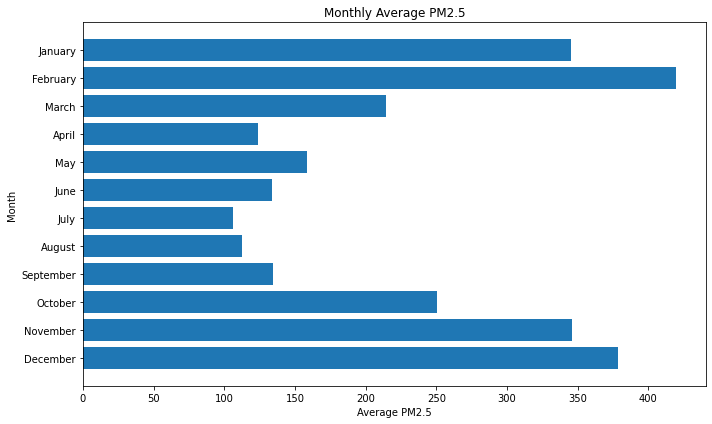

In [ ]:
# 2. Time Series Visualization
df_copy=df[['date', 'pm2_5']].copy()

df_copy['date'] = pd.to_datetime(df_copy['date'])

df_copy.set_index('date', inplace=True)

monthly_avg = df_copy.resample('ME').mean()
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
            7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
monthly_avg['Month'] = monthly_avg.index.month
monthly_avg['Month'] = monthly_avg['Month'].map(month_names)
monthly_avg_comb = monthly_avg.groupby('Month')['pm2_5'].mean()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
            'July', 'August', 'September', 'October', 'November', 'December']

monthly_avg_comb.index = pd.CategoricalIndex(monthly_avg_comb.index, categories=month_order, ordered=True)
monthly_avg_sorted = monthly_avg_comb.sort_index(ascending=False)

plt.figure(figsize=(10, 6))

# Creating a horizontal bar chart
plt.barh(monthly_avg_sorted.index, monthly_avg_sorted.values)

# Customizing the plot
plt.title('Monthly Average PM2.5')
plt.xlabel('Average PM2.5')
plt.ylabel('Month')
plt.tight_layout()

plt.show()

In [ ]:
# 3. Description of Time series
'''
Stationary: Yes, the data is stationary as the ADFuller test indicates.
Trends: There appear to be trends in the data. Mainly when transitioning to and from the winter months.
Seasonality: Yes, there appears to be seasonality in this data. The values are particularly high in the winter months and lower in the summer months.
'''

In [ ]:
# 4. TS models
'''
SARIMAX
The data was first resampled from hourly to daily and then modeled. I found some seasonality in the data and that is why i chose to use the SARIMAX model over the ARIMA model.
The SARIMAX model provided slightly better results when comparing the RMSE and MAPE. The SARIMAX model in this case may not be the best because it is not able to take recognize
some of the relationships between the different times series. For instance Nainesh had pointed out earlier that there is a high correlation between PM2_5 and CO pollution levels.
Using a model that can model that relationship might further improve the predictions

RMSE: 139.91
MAPE: 46.81%
'''
split_point = round((df_work.shape[0]*0.8)+3)
train, test = df_work['pm2_5'].iloc[:split_point], df_work['pm2_5'].iloc[split_point:]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history, order=(3, 0, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test.iloc[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.2f' % rmse)
mape = mean_absolute_percentage_error(test.values, predictions) * 100
print(f"MAPE: {mape:.2f}%")

RMSE: 139.91
MAPE: 46.81%


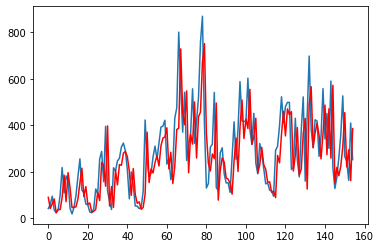

In [ ]:
# 5. Predictions
'''
SARIMAX Prediction
'''
plt.plot(test.values)
plt.plot(predictions, color='red')
plt.show()

## Sarthak's Contribution

## Data Visualization, Decomposition, Description of Time Series and predictions


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf,adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

FEAT_OFF=0 # Value if you want to calculate features (do not need to change as already caclulatted and uploaded on github)
DATA_NEW="../data/delhi_aqi_new.csv" # change with your path
DATA_OLD="../data/delhi_aqi.csv" # change with your path

"""
Utility Functions
"""

def day_part(hour):
    if hour in [4,5]:
        return "dawn"
    elif hour in [6,7]:
        return "early morning"
    elif hour in [8,9,10]:
        return "late morning"
    elif hour in [11,12,13]:
        return "noon"
    elif hour in [14,15,16]:
        return "afternoon"
    elif hour in [17, 18,19]:
        return "evening"
    elif hour in [20, 21, 22]:
        return "night"
    elif hour in [23,24,1,2,3]:
        return "midnight"


"""
Calculate Features
"""
def features():
    df=resample('H')

    for col in df.columns:
        if col!='date':
            df[col+'_diff_mean']=df[col].apply(lambda x:\
                x-np.mean(df[col].values))


    df['year']=df['date'].dt.year
    df['month']=df['date'].dt.month
    df['day']=df['date'].dt.day
    df['hour']=df['date'].dt.hour

    df['day_of_week']=df['date'].dt.day_of_week
    df['day_of_year']=df['date'].dt.day_of_year

    df['day_part']=df['hour'].apply(day_part)

    # mean of every pollutant
    mpo=df[['pm10','pm2_5','nh3','so2','o3','no2','no','co']].apply(np.mean,axis=0)

    if FEAT_OFF:
        df.to_csv('../data/delhi_aqi_new.csv',index=False)


"""
Resample Time Series, Returns dataframe with only the numeric columns
"""

def resample(sample:str='M'):
    df=pd.read_csv(DATA_NEW)

    df_nums=df.copy()

    df_nums['date']=pd.to_datetime(arg=df_nums['date'],format="%Y-%m-%d %H:%M:%S")
    df_nums.set_index('date',inplace=True)
    if sample=='M':
        df_nums=df_nums.resample('M').agg({'pm10':np.mean,'nh3':np.mean,
                                  'pm2_5':np.mean,'co':np.mean,'no':np.mean,
                                  'no2':np.mean,'o3':np.mean,'so2':np.mean})

    elif sample=='D':
        df_nums=df_nums.resample('D').agg({'pm10':np.mean,'nh3':np.mean,
                                  'pm2_5':np.mean,'co':np.mean,'no':np.mean,
                                  'no2':np.mean,'o3':np.mean,'so2':np.mean})

    else:
        None


    # In case multiple values for the same date
    df_nums=df_nums.groupby(by='date').agg({'pm10':np.mean,'nh3':np.mean,
                                  'pm2_5':np.mean,'co':np.mean,'no':np.mean,
                                  'no2':np.mean,'o3':np.mean,'so2':np.mean}).reset_index()


    return df,df_nums


"""
Plots for Pollution
"""

def Polplots(sample:str,dtformat:str='manual'):

    df,df_nums=resample(sample)

    # Line Plot for pm10 and pm2_5

    if sample!='H':
        tit='Monthly mean pm10 and pm 2.5 pollutant levels'

    else:tit='Hourly mean pm10 pollutant levels'

    ax=plt.subplot(1,1,1)

    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.set_title(tit)
    ax.set_ylabel('Pollutant Values')

    ax.set_xlabel('Date')


    ax.grid(True)
    ax.plot(df_nums['date'].values,df_nums['pm10'].values,'-b')
    ax.plot(df_nums['date'].values,df_nums['pm2_5'].values,'-r')
    ax.legend(['pm10','pm 2.5'])


    if dtformat!='manual':
        ax.xaxis.set_major_formatter(
            mdates.ConciseDateFormatter(ax.xaxis.get_major_locator())
        )
    else:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

    ax.tick_params(axis='x',direction='in',
                   rotation=40,labelsize='small')

    plt.show()

    # violin plots of pollutants levels based on day of the week

    plt.figure(figsize=(12,7))
    sns.violinplot(data=df, x="pm10", y="day_part",orient='h',hue='day_part')
    plt.title("Distribution of pm10 pollutants based on part of day")
    plt.xticks(rotation=20)
    plt.show()

    # Striplots for co pollutant levels based on day of the week
    sns.stripplot(data=df, x="co", y="day_part",orient='h',hue='day_part')
    plt.title("CO pollutants levels based on part of day")
    plt.xticks(rotation=20)
    plt.show()


def decompose(toplot:bool):
    _,df=resample('D')
    df.fillna(df.mean(),inplace=True)

    if toplot:
        mdec=seasonal_decompose(df['pm2_5'],model='multiplicative',period=12)
        adec=seasonal_decompose(df['pm2_5'],model='additive',period=12)

        mdec.plot()
        plt.suptitle('Mul')
        adec.plot()
        plt.suptitle('Add')
        plt.show()

        # Draw Plot

        # The acf and pacf plots suggest that there might be a trend and seasonal component involved in our data
        fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
        plot_acf(df['pm2_5'].tolist(), lags=10, ax=axes[0])
        plot_pacf(df['pm2_5'].tolist(), lags=10, ax=axes[1])
        plt.show()

    adf=adfuller(x=df['pm2_5'])
    print("The p value is {}".format(adf[1]))

    if adf[1]<0.05:
        print("We reject the null hypothesis and say the series is stationary")

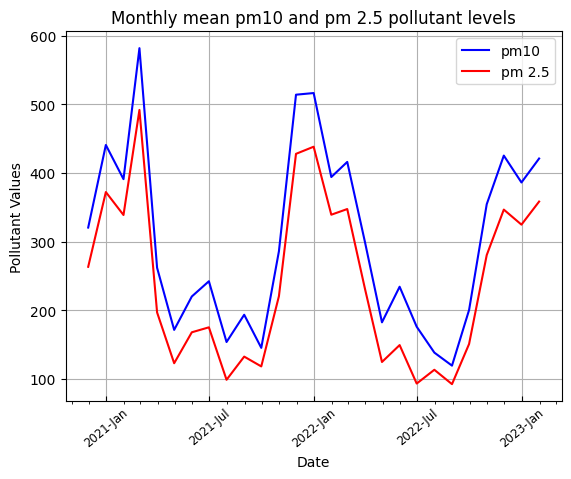

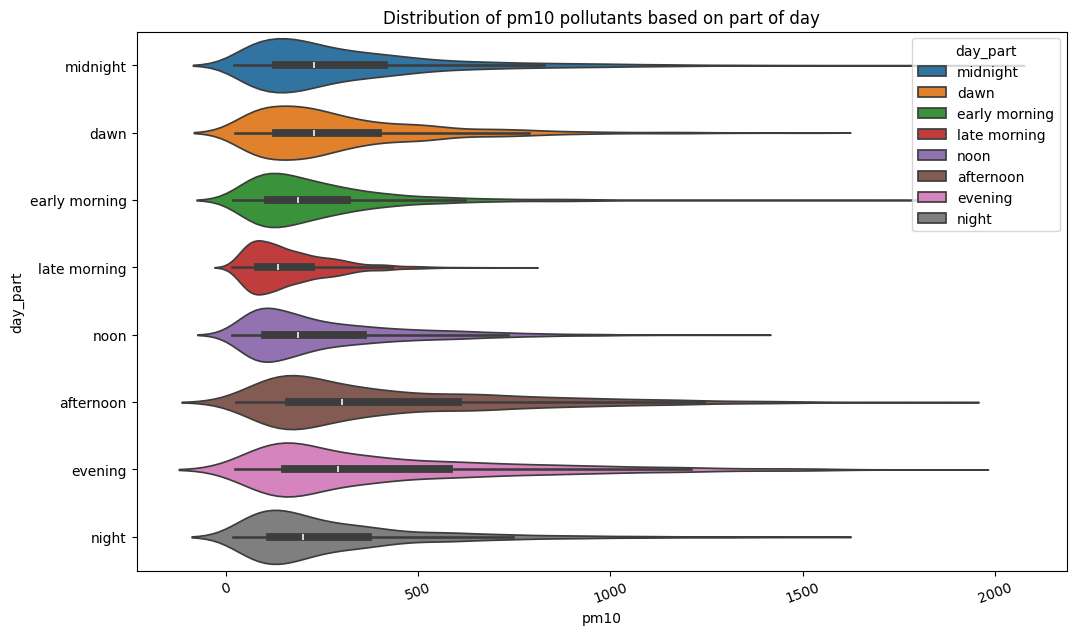

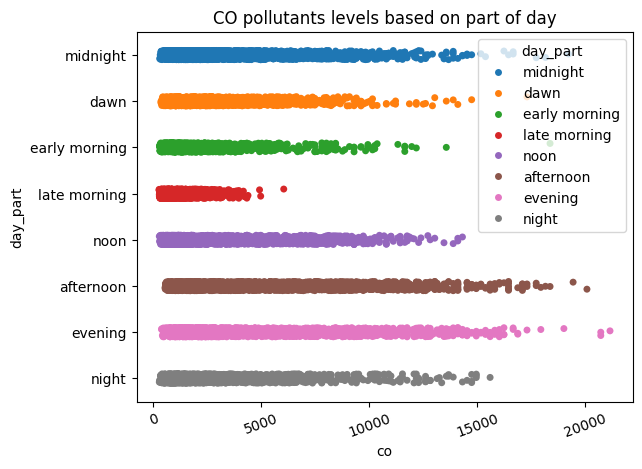

In [ ]:
# Visualizations

## The monthly pm10 and pm 2.5 values (sampled half yearly) displayed below
## The violinplots display the distribution of pollutants based on part of the day, Afternoon and evening shows the highest median levels of pollutants,
## because maximum people travel during the afternoon, In evening everyone is returning back home which results in an increase in these levels
Polplots('M')

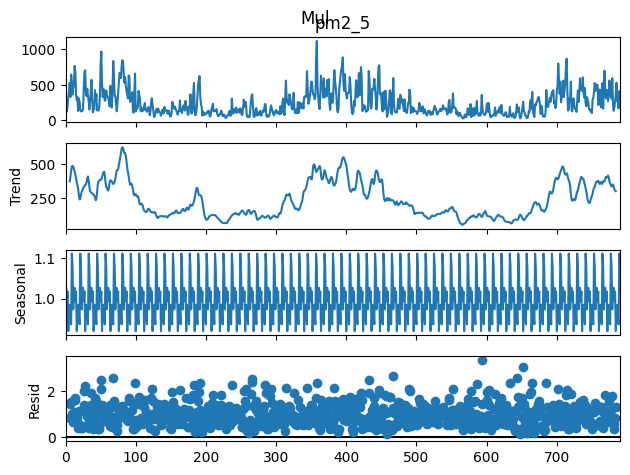

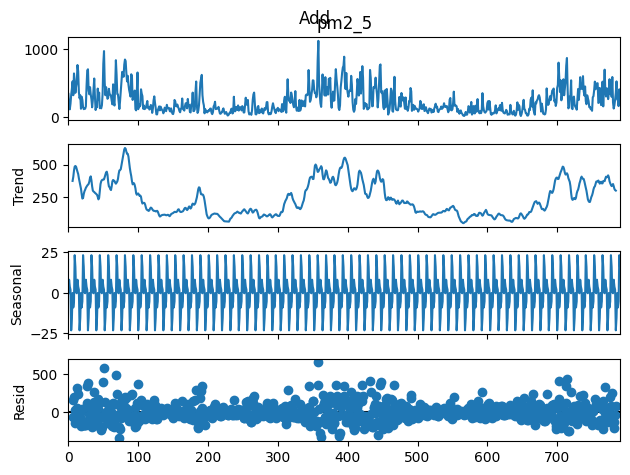

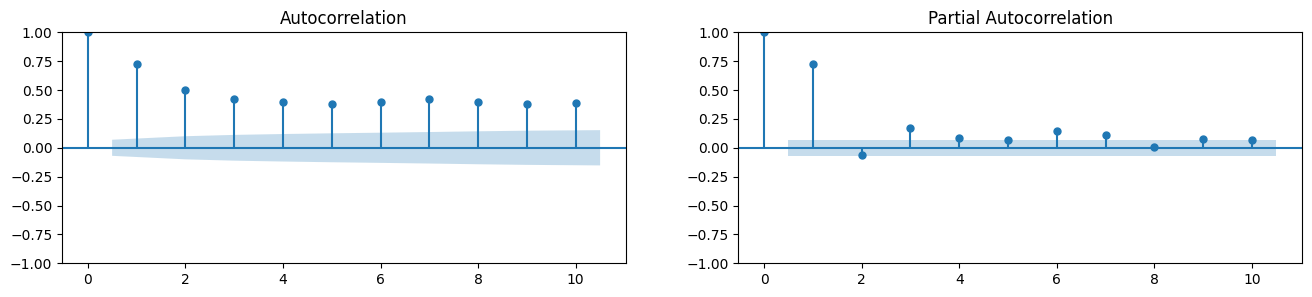

The p value is 0.004732262366003357
We reject the null hypothesis and say the series is stationary


In [ ]:
# Decomposition

decompose(True)

In [ ]:
# Description of the Time Series

"""
Trend Component:

In both multiplicative and additive decompositions, the trend component shows fluctuations over time. This indicates that the long-term movement of PM2.5 concentrations isn't stable. Instead, there are periods of increase and decrease that could relate to external factors, such as changes in emissions policies, economic activity, or seasonal factors that are not captured by the seasonal component (like crop burning seasons or festivals).

Seasonal Component:

The seasonal patterns are quite pronounced, indicating that there is a significant seasonal influence on PM2.5 levels. In the multiplicative decomposition, the seasonal effect seems to fluctuate around a mean, suggesting that the seasonal influence multiplies with the level of the series. In the additive model, the seasonal effect is more consistent in amplitude over time.
The presence of a strong seasonal component may suggest that specific times of the year consistently have higher or lower PM2.5 levels, possibly due to factors like temperature changes affecting air stability, seasonal variations in human activity, or natural cycles like plant growth or decay.

Residual Component:

The residual or irregular component captures the noise after the trend and seasonal components have been accounted for. Ideally, this should be white noise, meaning there should be no discernible pattern.
In both decompositions, the residuals don't show any obvious patterns, suggesting that the model has captured most of the systematic information in the data. However, there seems to be some volatility clustering in residuals - periods of high variability followed by periods of calm. This could suggest some additional, unexplained influences on PM2.5 levels or possibly point to non-linear dynamics that aren't captured by these decomposition models.
"""

## TS Models

c:\Users\OMEN\Desktop\IUB SEM 2\Time Series\Time-Series-Project\src\sarthak_eda.py:87: FutureWarning: The provided callable <function mean at 0x000001CF2D44A980> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_nums=df_nums.resample('D').agg({'pm10':np.mean,'nh3':np.mean,
c:\Users\OMEN\Desktop\IUB SEM 2\Time Series\Time-Series-Project\src\sarthak_eda.py:96: FutureWarning: The provided callable <function mean at 0x000001CF2D44A980> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_nums=df_nums.groupby(by='date').agg({'pm10':np.mean,'nh3':np.mean,
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\OMEN\anaconda3\envs\smm\Lib\site-pack

Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.39it/s]


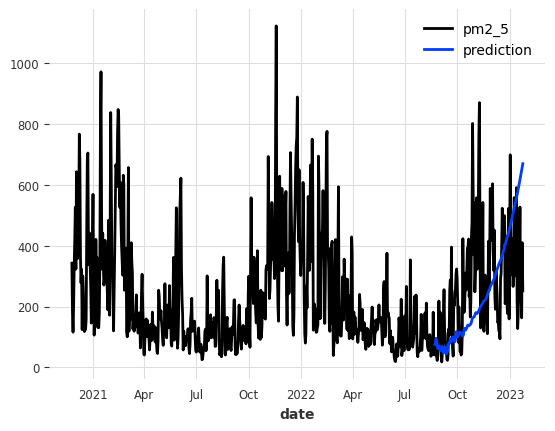

          nbeats
mape   66.446879
rmse  197.272475


c:\Users\OMEN\Desktop\IUB SEM 2\Time Series\Time-Series-Project\src\sarthak_eda.py:87: FutureWarning: The provided callable <function mean at 0x000001CF2D44A980> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_nums=df_nums.resample('D').agg({'pm10':np.mean,'nh3':np.mean,
c:\Users\OMEN\Desktop\IUB SEM 2\Time Series\Time-Series-Project\src\sarthak_eda.py:96: FutureWarning: The provided callable <function mean at 0x000001CF2D44A980> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_nums=df_nums.groupby(by='date').agg({'pm10':np.mean,'nh3':np.mean,


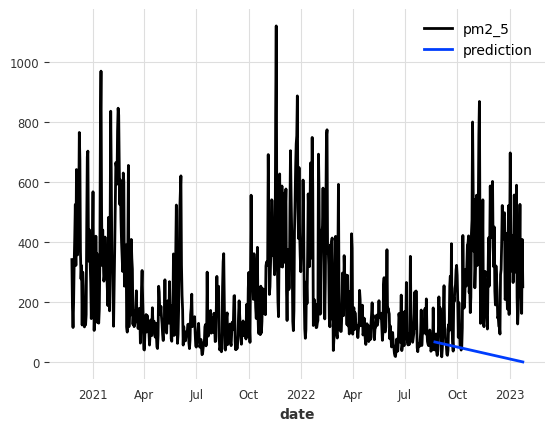

           naive
mape   82.416034
rmse  301.052248


c:\Users\OMEN\Desktop\IUB SEM 2\Time Series\Time-Series-Project\src\sarthak_eda.py:87: FutureWarning: The provided callable <function mean at 0x000001CF2D44A980> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_nums=df_nums.resample('D').agg({'pm10':np.mean,'nh3':np.mean,
c:\Users\OMEN\Desktop\IUB SEM 2\Time Series\Time-Series-Project\src\sarthak_eda.py:96: FutureWarning: The provided callable <function mean at 0x000001CF2D44A980> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_nums=df_nums.groupby(by='date').agg({'pm10':np.mean,'nh3':np.mean,


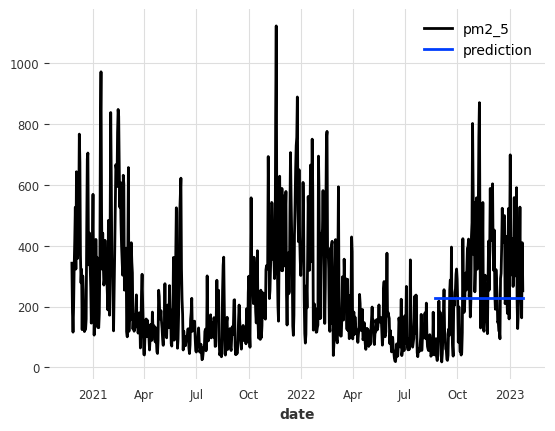

      naive_mean
mape  101.155755
rmse  177.018677


In [2]:
import math
import glob
import pandas as pd
import matplotlib.pyplot as plt

import sktime
import numpy as np
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

from sktime.regression.dummy import *
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.utils.plotting import plot_series

from darts import TimeSeries
from darts.datasets import WeatherDataset
from darts.models import NBEATSModel, NaiveDrift, NaiveMean

from darts.metrics import mape


from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error


from sarthak_eda import resample

DATA_NEW="../data/delhi_aqi_new.csv"


def sktimemodel(train_size:int=0.8):
    """df=pd.read_csv(DATA_NEW)

    df['date']=pd.to_datetime(arg=df['date'],format="%Y-%m-%d %H:%M:%S")
    df.set_index('date',inplace=True)

    df=df.resample('D').agg({'pm10':np.mean,'nh3':np.mean,
                                  'pm2_5':np.mean,'co':np.mean,'no':np.mean,
                                  'no2':np.mean,'o3':np.mean,'so2':np.mean})
    """

    _,df=resample("D")

    df.fillna(df.mean(),inplace=True)

    #print(df.isnull().sum())
    df.set_index('date',inplace=True)
    count_df=round((df.shape[0]*train_size)+3)
    train_df=df.iloc[:count_df,:]
    test_df=df.iloc[count_df:,:]

    # Naive Regressor model
    naive_reg=NaiveForecaster(strategy='mean')
    naive_reg.fit(train_df['pm2_5'])

    y_pred =naive_reg.predict(fh=np.arange(1,157))

    print(y_pred)


def modelDartsNbeats(sample_freq:str,train_size:int=0.8):

    _,df=resample(sample_freq)

    df.fillna(df.mean(),inplace=True)

    df.set_index('date',inplace=True)
    count_df=round((df.shape[0]*train_size)+3)
    train_df=df.iloc[:count_df,:]
    test_df=df.iloc[count_df:,:]


    if sample_freq=='H':
        series= TimeSeries.from_series(df['pm2_5'],fill_missing_dates=True,freq='H')
    else:
        series= TimeSeries.from_series(df['pm2_5'])

    series_train=series[:count_df]
    series_test=series[count_df:]

    if 'nbeats_model.pt' in glob.glob('*.pt'):
        model=NBEATSModel.load(path='nbeats_model.pt')
    else:
        model=NBEATSModel(
            input_chunk_length=30,
            output_chunk_length=1,
            n_epochs=25,
            activation='ReLU')

        model.fit(series_train)
        model.save("nbeats_model.pt")

    pred=model.predict(len(series_test))

    #actual=np.array([[x] for x in test_df['pm2_5'].values])
    actual=series_test.values()



    series.plot()
    pred.plot(label='prediction')
    plt.show()
    return actual,pred,'nbeats'


def modelDartsNaive(sample_freq:str,train_size:int=0.8):

    _,df=resample(sample_freq)

    df.fillna(df.mean(),inplace=True)

    df.set_index('date',inplace=True)
    count_df=round((df.shape[0]*train_size)+3)
    train_df=df.iloc[:count_df,:]
    test_df=df.iloc[count_df:,:]


    if sample_freq=='H':
        series= TimeSeries.from_series(df['pm2_5'],fill_missing_dates=True,freq='H')
    else:
        series= TimeSeries.from_series(df['pm2_5'])

    series_train=series[:count_df]
    series_test=series[count_df:]

    if 'naive_model.pkl' in glob.glob('*.pkl'):
        model=NaiveDrift.load(path='naive_model.pkl')
    else:
        model=NaiveDrift()

        model.fit(series_train)
        model.save("naive_model.pkl")

    pred=model.predict(len(series_test))

    #actual=np.array([[x] for x in test_df['pm2_5'].values])
    actual=series_test.values()



    series.plot()
    pred.plot(label='prediction')
    plt.show()
    return actual,pred,'naive'


def modelDartsNaiveMean(sample_freq:str,train_size:int=0.8):

    _,df=resample(sample_freq)

    df.fillna(df.mean(),inplace=True)

    df.set_index('date',inplace=True)
    count_df=round((df.shape[0]*train_size)+3)
    train_df=df.iloc[:count_df,:]
    test_df=df.iloc[count_df:,:]


    if sample_freq=='H':
        series= TimeSeries.from_series(df['pm2_5'],fill_missing_dates=True,freq='H')
    else:
        series= TimeSeries.from_series(df['pm2_5'])

    series_train=series[:count_df]
    series_test=series[count_df:]

    if 'naivemean_model.pkl' in glob.glob('*.pkl'):
        model=NaiveMean.load(path='naivemean_model.pkl')
    else:
        model=NaiveMean()

        model.fit(series_train)
        model.save("naivemean_model.pkl")

    pred=model.predict(len(series_test))

    #actual=np.array([[x] for x in test_df['pm2_5'].values])
    actual=series_test.values()

    

    series.plot()
    pred.plot(label='prediction')
    plt.show()
    return actual,pred,'naive_mean'


def metrics(modelFunc):

    m={}

    actual,pred,mname=modelFunc
    model=[mname]
    error={'mape':mean_absolute_percentage_error,
           'rmse':mean_squared_error}
    #print("Mean absolute percentage error is {:.2f}%."\
    #      .format(mean_absolute_percentage_error(actual, pred.values())))


    for mod in model:
        e_dict={}
        for i,e in enumerate(error.items()):

            if e[0]=='rmse':
                e_dict[e[0]]=math.sqrt(e[1](actual, pred.values()))
            else:
                e_dict[e[0]]=e[1](actual, pred.values())*100

        m[mod]=e_dict

    df=pd.DataFrame(m)
    print(df)





metrics(modelDartsNbeats('D'))
metrics(modelDartsNaive('D'))
metrics(modelDartsNaiveMean('D'))

In [ ]:
## Choice of Model

"""
My nbeats model is comparitive in performance to the SARIMAX model, But it can perform better if we tune the hyperparameters like adding additional covariates
for improving the model, Number of epochs its trained on, learning scheduler for better training with decaying learning rate.

In the domain of air quality forecasting, where the target variable, PM2.5, is influenced by complex and dynamic systems,
traditional time series forecasting models often fall short.
The inherent non-linearities and irregularities in the data necessitate an approach that can learn from the data in a non-prescriptive manner.
To this end, the Neural Basis Expansion Analysis (N-BEATS) model is selected for its exceptional capabilities in handling intricate time series data without the need for explicitly defined temporal structures.

N-BEATS at a Glance:

N-BEATS stands out for its unique architecture, eschewing the common recurrent or convolutional layers typical of deep learning time series models. It instead relies on a series of fully connected layers arranged in blocks, with each block designed to capture a different type of temporal pattern in the data. \
This structure allows the model to perform a form of automated feature extraction, learning the underlying trends and seasonality from the data itself.

Reason for Model Selection:

Flexibility and Adaptability: N-BEATS is agnostic to the nature of the time series, making it applicable to a wide range of forecasting tasks,
including environmental data like PM2.5 levels, which are subject to frequent and unpredictable changes.

High Performance: Demonstrated to outperform several benchmark models in time series forecasting, N-BEATS offers a promising approach to improving the accuracy and reliability of PM2.5 forecasts, critical for health advisory and policy-making.

Interpretability and Decomposition: One of the key features of N-BEATS is its ability to decompose forecasts into interpretable components, such as trend and seasonality. This is particularly useful in environmental studies where understanding the driving factors behind pollution levels is as important as the forecast itself.

No Need for Seasonal Adjustment: Unlike many models that require pre-processing steps like seasonal adjustment, N-BEATS can directly model the raw data, simplifying the forecasting pipeline and reducing the potential for data distortion.

Ensemble Learning: N-BEATS naturally lends itself to an ensemble approach, where multiple instances of the model, each trained on different aspects of the data, contribute to a final, aggregated forecast. This can potentially lead to more robust predictions.



The Naive Drift and Naive mean model provides a simple yet effective forecasting baseline

Explaination:

The Naive Drift model is a simplistic forecasting method that extends the last observed trend into the future.
This model assumes that the changes between recent observations are a good predictor of future trends,
which allows for a straightforward, linear extrapolation of the data. The Naive mean on the other hand just predicts the mean value


Baseline Forecasting: The Naive Drift and Naive Mean model acts as a sanity check against more complex models like N-BEATS. Its forecasts serve as a benchmark to ensure that the advanced model provides a significant improvement over simpler methods.

Simplicity and Speed: Due to its minimal computational requirements, the Naive Drift model is incredibly fast to run, making it ideal for quick estimates or when computational resources are limited.

Trend Extension: In the case of PM2.5 forecasting, where short-term trends can be important due to sudden changes in environmental conditions, the Naive Drift can offer valuable insights into immediate future values.

Complementary Analysis: The Naive Drift can complement the detailed decomposition provided by N-BEATS. Where N-BEATS excels in capturing complex patterns, Naive Drift offers a clear view of the prevailing trend without the noise of other components.


Out of the two models I trained, Nbeats clearly performes better than a naive mdoel with lower rmse and mape values.
"""

##Nainesh's Contribution

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams

In [2]:
data = pd.read_csv('/content/delhi_aqi_new.csv')

print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18776 entries, 0 to 18775
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             18776 non-null  object 
 1   pm10             18776 non-null  float64
 2   nh3              18776 non-null  float64
 3   pm2_5            18776 non-null  float64
 4   co               18776 non-null  float64
 5   no               18776 non-null  float64
 6   no2              18776 non-null  float64
 7   o3               18776 non-null  float64
 8   so2              18776 non-null  float64
 9   pm10_diff_mean   18776 non-null  float64
 10  nh3_diff_mean    18776 non-null  float64
 11  pm2_5_diff_mean  18776 non-null  float64
 12  co_diff_mean     18776 non-null  float64
 13  no_diff_mean     18776 non-null  float64
 14  no2_diff_mean    18776 non-null  float64
 15  o3_diff_mean     18776 non-null  float64
 16  so2_diff_mean    18776 non-null  float64
 17  year        

In [3]:
# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y %H:%M')

# Set the 'date' column as the index
data.set_index('date', inplace=True)

In [4]:
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18776 entries, 2020-11-25 01:00:00 to 2023-01-24 08:00:00
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pm10             18776 non-null  float64
 1   nh3              18776 non-null  float64
 2   pm2_5            18776 non-null  float64
 3   co               18776 non-null  float64
 4   no               18776 non-null  float64
 5   no2              18776 non-null  float64
 6   o3               18776 non-null  float64
 7   so2              18776 non-null  float64
 8   pm10_diff_mean   18776 non-null  float64
 9   nh3_diff_mean    18776 non-null  float64
 10  pm2_5_diff_mean  18776 non-null  float64
 11  co_diff_mean     18776 non-null  float64
 12  no_diff_mean     18776 non-null  float64
 13  no2_diff_mean    18776 non-null  float64
 14  o3_diff_mean     18776 non-null  float64
 15  so2_diff_mean    18776 non-null  float64
 16  year             18776 

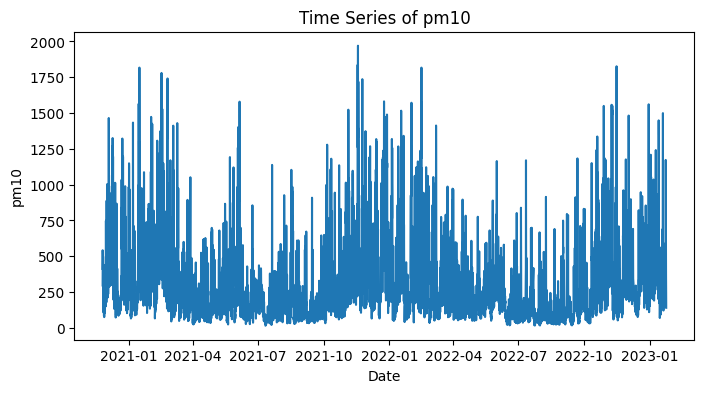

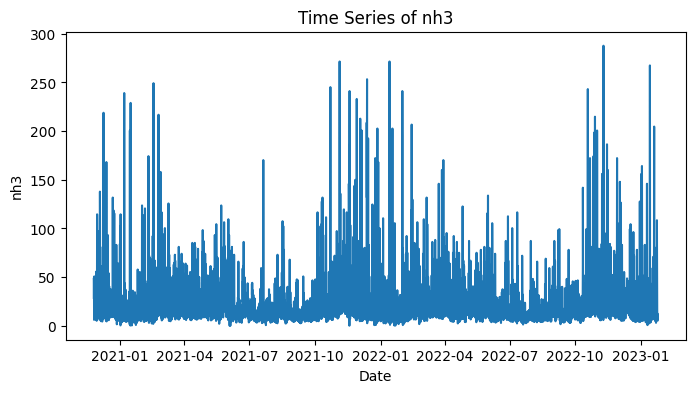

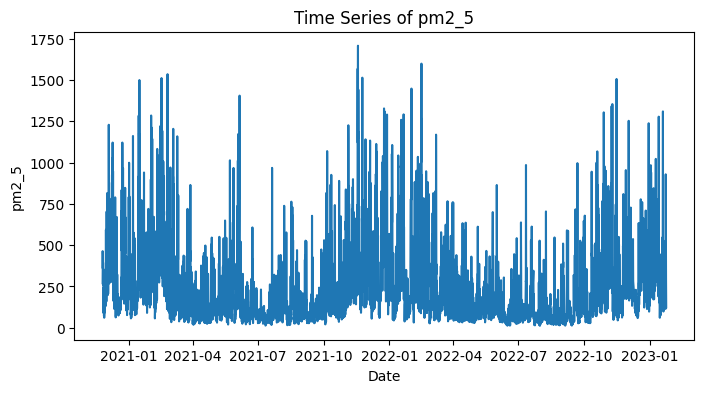

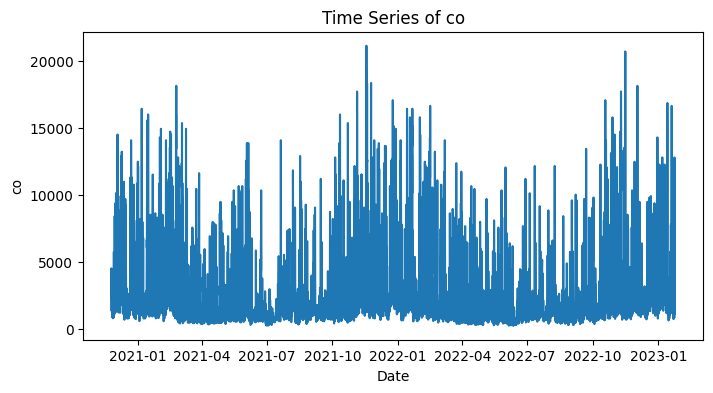

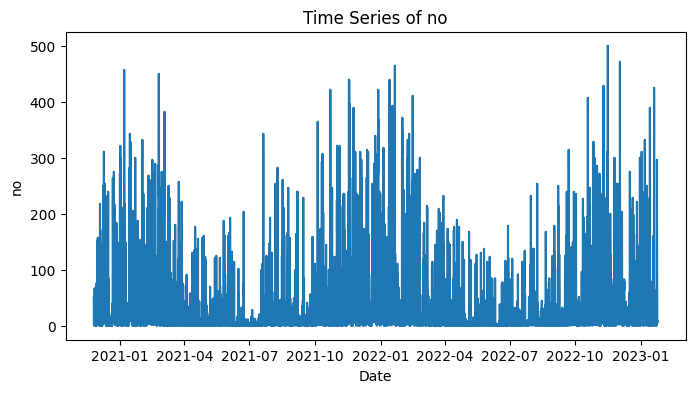

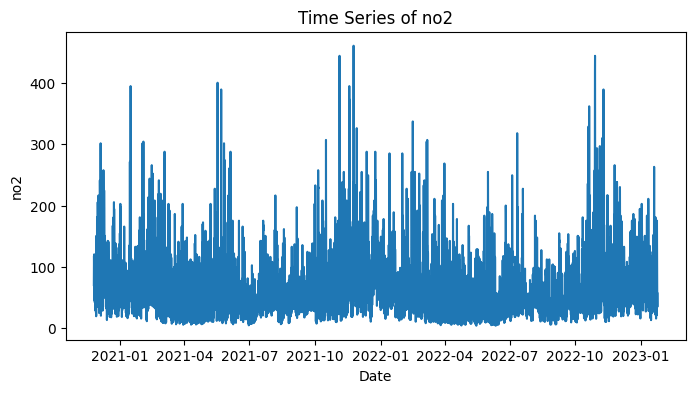

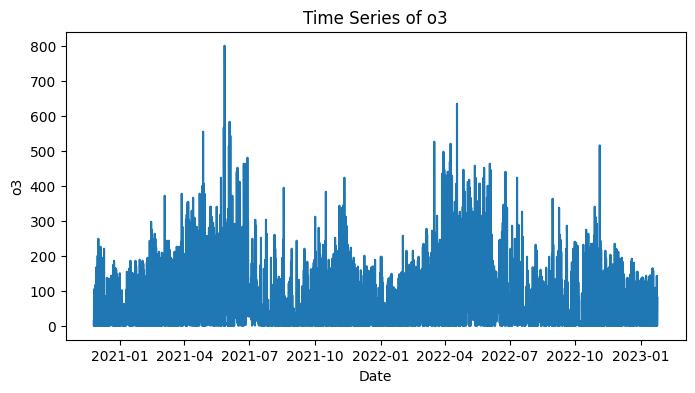

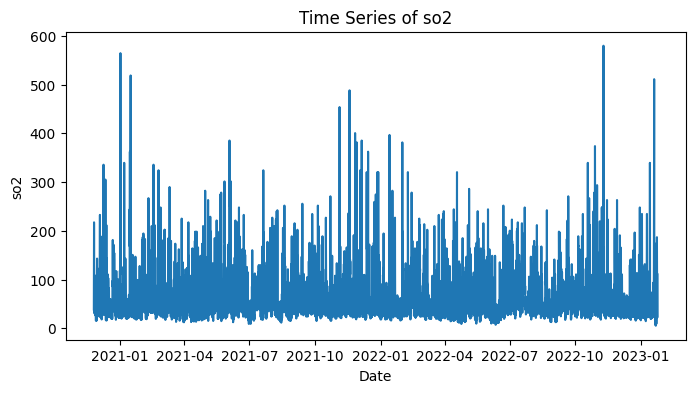

In [ ]:
# List of pollutants
pollutants = ['pm10', 'nh3', 'pm2_5', 'co', 'no', 'no2', 'o3', 'so2']

# Plot each pollutant
for pollutant in pollutants:
    plt.figure(figsize=(8,4))
    plt.plot(data.index, data[pollutant])
    plt.title(f'Time Series of {pollutant}')
    plt.xlabel('Date')
    plt.ylabel(pollutant)
    plt.show()


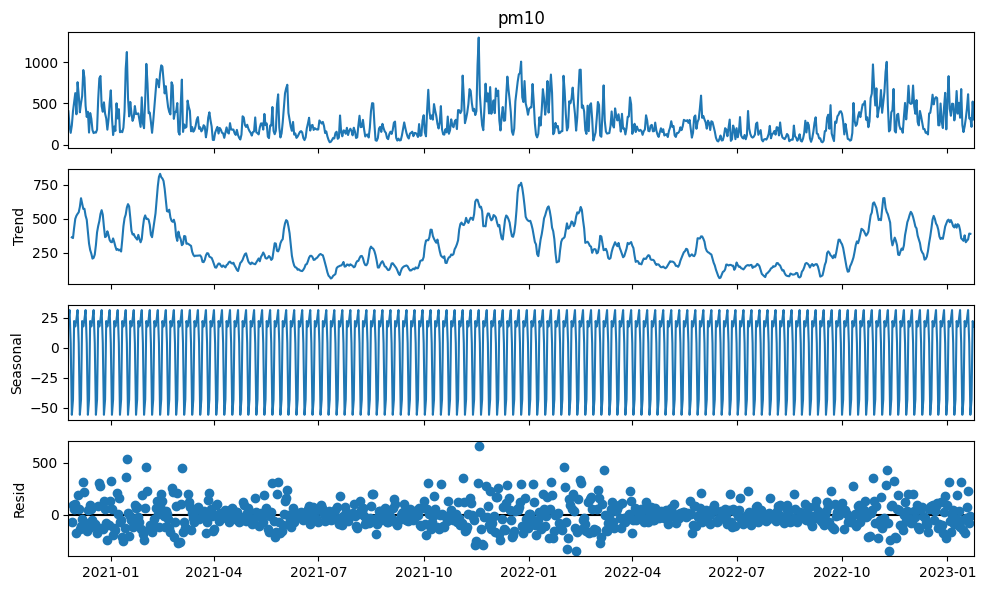

In [ ]:
pollutant = 'pm10'

daily_data = data[pollutant].resample('D').mean()

daily_data = data[pollutant].resample('D').mean().interpolate()

# Fill remaining missing values
daily_data = daily_data.fillna(method='bfill')  # backfill
daily_data = daily_data.fillna(method='ffill')  # forward fill

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data)

# Plot the original data, the trend, the seasonality, and the residuals
rcParams['figure.figsize'] = 10, 6
fig = decomposition.plot()
plt.show()


Original Time Series (pm10): The pm10 levels fluctuate over time, with peaks reaching up to around 1000 and troughs near zero. This suggests variability in the pm10 levels.

Trend: The trend component shows oscillations between approximately 250 and 750. This suggests that while there are fluctuations in the pm10 levels, there isn’t a clear upward or downward trend over the period from January 2021 to January 2023.

Seasonality: The consistent oscillations in the seasonal component indicate a seasonal pattern in the data. This suggests that there are repeating patterns in the pm10 levels that occur at regular intervals.

Residuals: The residuals represent variations not explained by either trend or seasonality. The scattered points in the residual plot suggest that there might be other factors influencing the pm10 levels that are not captured by the trend and seasonal components.

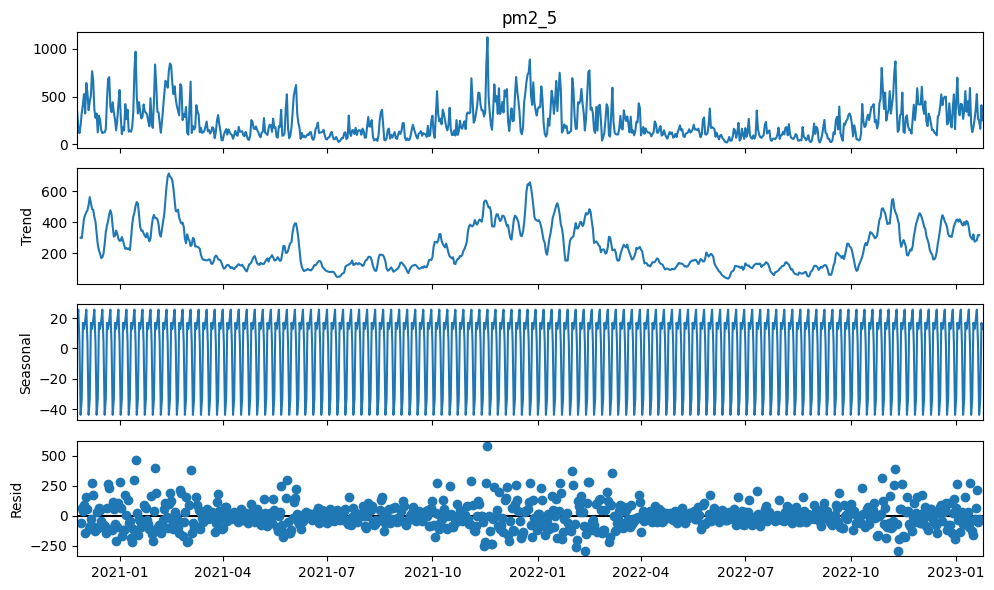

In [ ]:
pollutant = 'pm2_5'

daily_data = data[pollutant].resample('D').mean()

daily_data = data[pollutant].resample('D').mean().interpolate()

# Fill remaining missing values
daily_data = daily_data.fillna(method='bfill')  # backfill
daily_data = daily_data.fillna(method='ffill')  # forward fill

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data)

# Plot the original data, the trend, the seasonality, and the residuals
rcParams['figure.figsize'] = 10, 6
fig = decomposition.plot()
plt.show()


Original Time Series (pm2_5): The pm2_5 levels fluctuate over time. This suggests variability in the pm2_5 levels.

Trend: The trend component shows a smoother version of the observed data, highlighting general trends without short-term fluctuations.

Seasonality: The repeating patterns in the seasonal component indicate a seasonal pattern in the data. This suggests that there are repeating patterns in the pm2_5 levels that occur at regular intervals.

Residuals: The residuals represent variations not explained by either trend or seasonality. The scattered points in the residual plot suggest that there might be other factors influencing the pm2_5 levels that are not captured by the trend and seasonal components.

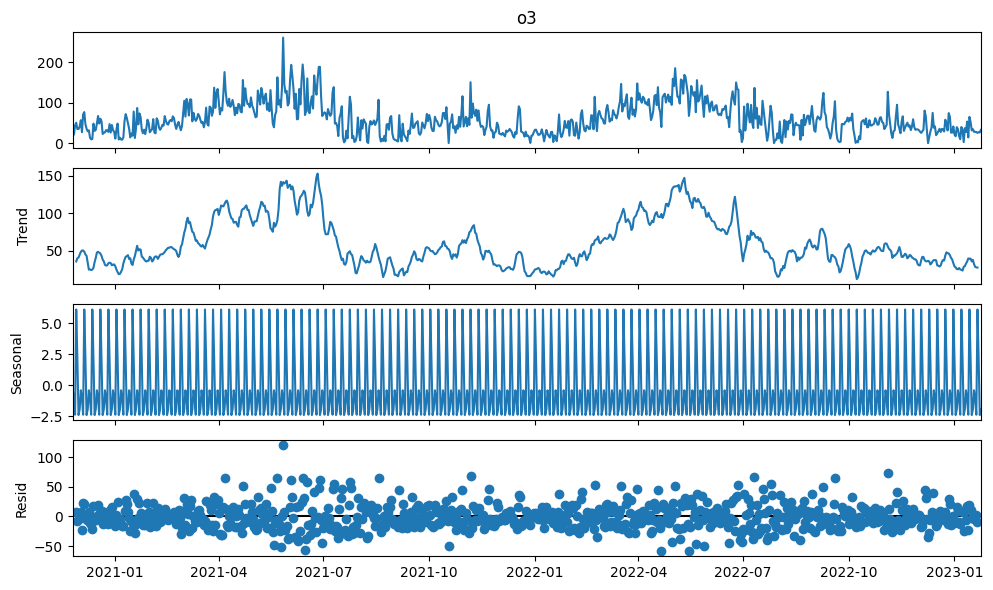

In [ ]:
pollutant = 'o3'

daily_data = data[pollutant].resample('D').mean()

daily_data = data[pollutant].resample('D').mean().interpolate()

# Fill remaining missing values
daily_data = daily_data.fillna(method='bfill')  # backfill
daily_data = daily_data.fillna(method='ffill')  # forward fill

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data)

# Plot the original data, the trend, the seasonality, and the residuals
rcParams['figure.figsize'] = 10, 6
fig = decomposition.plot()
plt.show()


Original Time Series (o3): The o3 levels fluctuate over time. This suggests variability in the o3 levels.

Trend: The trend component shows a smoother version of the observed data, highlighting general trends without short-term fluctuations.

Seasonality: The repeating patterns in the seasonal component indicate a seasonal pattern in the data. This suggests that there are repeating patterns in the o3 levels that occur at regular intervals.

Residuals: The residuals represent variations not explained by either trend or seasonality. The scattered points in the residual plot suggest that there might be other factors influencing the o3 levels that are not captured by the trend and seasonal components.

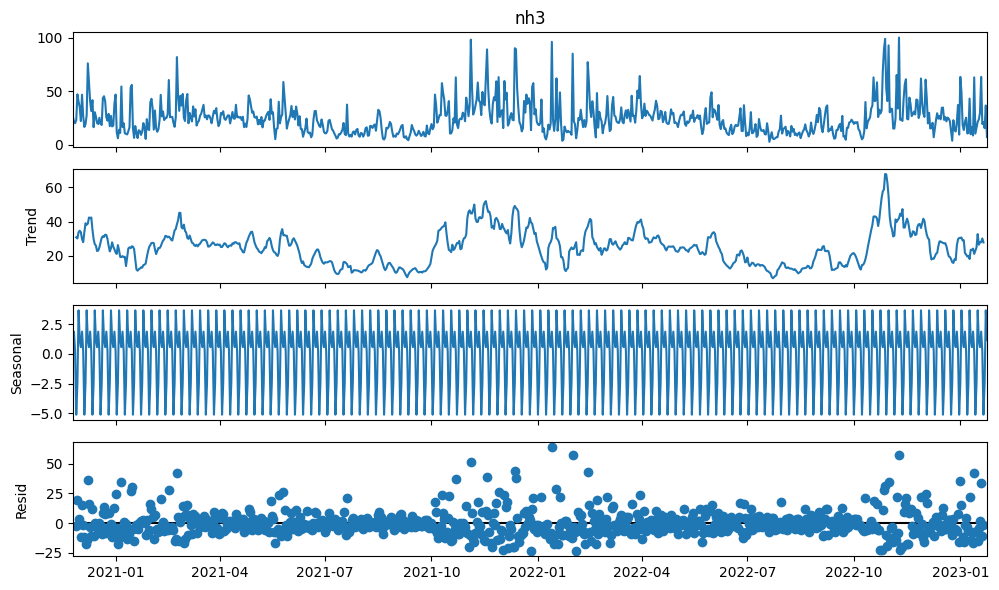

In [ ]:
pollutant = 'nh3'

daily_data = data[pollutant].resample('D').mean()

daily_data = data[pollutant].resample('D').mean().interpolate()

# Fill remaining missing values
daily_data = daily_data.fillna(method='bfill')  # backfill
daily_data = daily_data.fillna(method='ffill')  # forward fill

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data)

# Plot the original data, the trend, the seasonality, and the residuals
rcParams['figure.figsize'] = 10, 6
fig = decomposition.plot()
plt.show()


Original Time Series (nh3): The nh3 levels fluctuate over time. This suggests variability in the nh3 levels.

Trend: The trend component shows a smoother version of the observed data, highlighting general trends without short-term fluctuations.

Seasonality: The repeating patterns in the seasonal component indicate a seasonal pattern in the data. This suggests that there are repeating patterns in the nh3 levels that occur at regular intervals.

Residuals: The residuals represent variations not explained by either trend or seasonality. The scattered points in the residual plot suggest that there might be other factors influencing the nh3 levels that are not captured by the trend and seasonal components.

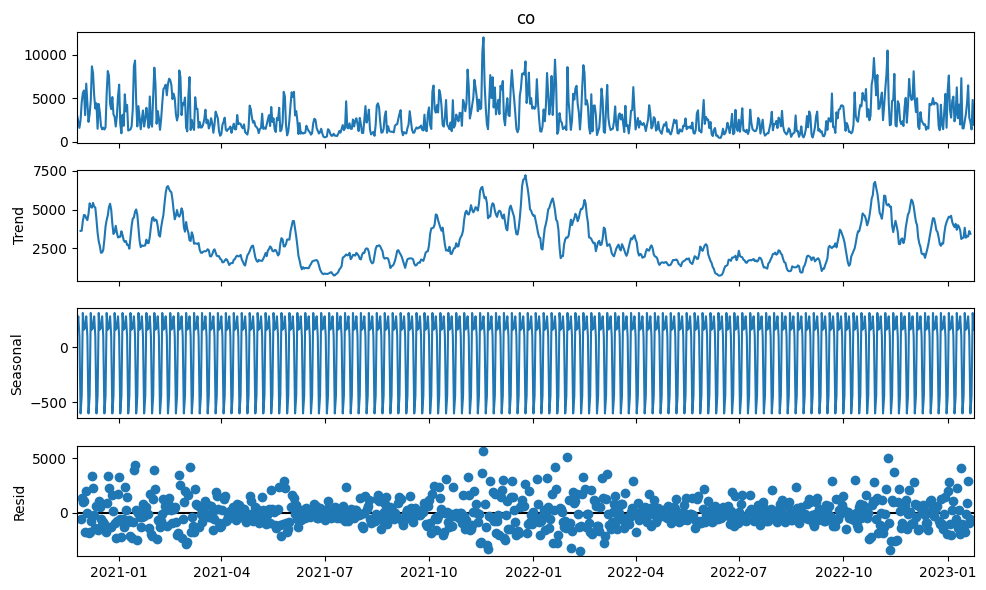

In [ ]:
pollutant = 'co'

daily_data = data[pollutant].resample('D').mean()

daily_data = data[pollutant].resample('D').mean().interpolate()

# Fill remaining missing values
daily_data = daily_data.fillna(method='bfill')  # backfill
daily_data = daily_data.fillna(method='ffill')  # forward fill

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data)

# Plot the original data, the trend, the seasonality, and the residuals
rcParams['figure.figsize'] = 10, 6
fig = decomposition.plot()
plt.show()


Original Time Series (CO): The CO levels fluctuate over time. This suggests variability in the CO levels.

Trend: The trend component shows a smoother version of the observed data, highlighting general trends without short-term fluctuations.

Seasonality: The repeating patterns in the seasonal component indicate a seasonal pattern in the data. This suggests that there are repeating patterns in the CO levels that occur at regular intervals.

Residuals: The residuals represent variations not explained by either trend or seasonality. The scattered points in the residual plot suggest that there might be other factors influencing the CO levels that are not captured by the trend and seasonal components.

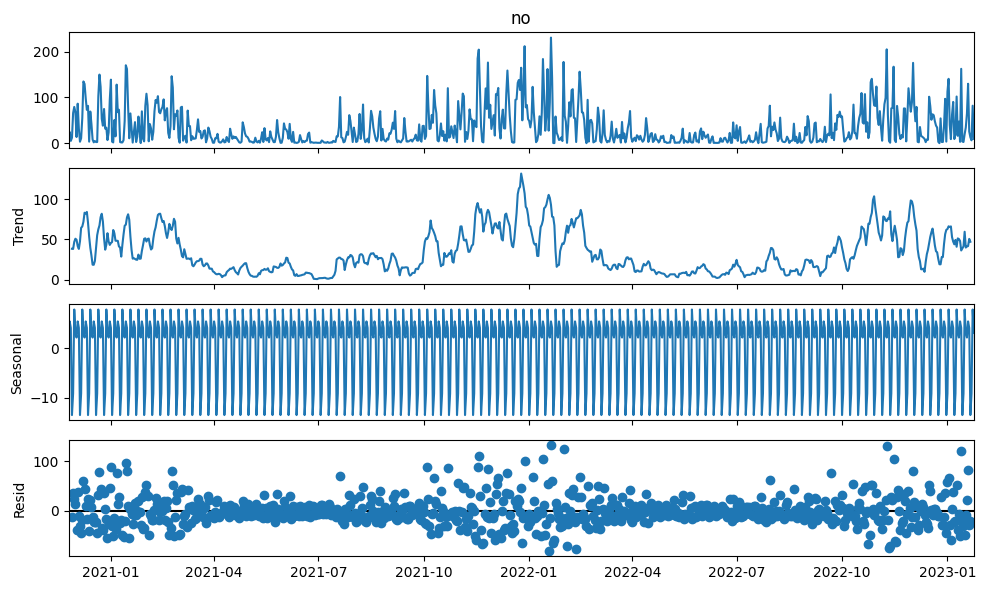

In [ ]:
pollutant = 'no'

daily_data = data[pollutant].resample('D').mean()

daily_data = data[pollutant].resample('D').mean().interpolate()

# Fill remaining missing values
daily_data = daily_data.fillna(method='bfill')  # backfill
daily_data = daily_data.fillna(method='ffill')  # forward fill

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data)

# Plot the original data, the trend, the seasonality, and the residuals
rcParams['figure.figsize'] = 10, 6
fig = decomposition.plot()
plt.show()


Original Time Series (no): The no levels fluctuate over time. This suggests variability in the no levels.

Trend: The trend component shows a smoother version of the observed data, highlighting general trends without short-term fluctuations.

Seasonality: The repeating patterns in the seasonal component indicate a seasonal pattern in the data. This suggests that there are repeating patterns in the no levels that occur at regular intervals.

Residuals: The residuals represent variations not explained by either trend or seasonality. The scattered points in the residual plot suggest that there might be other factors influencing the no levels that are not captured by the trend and seasonal components.

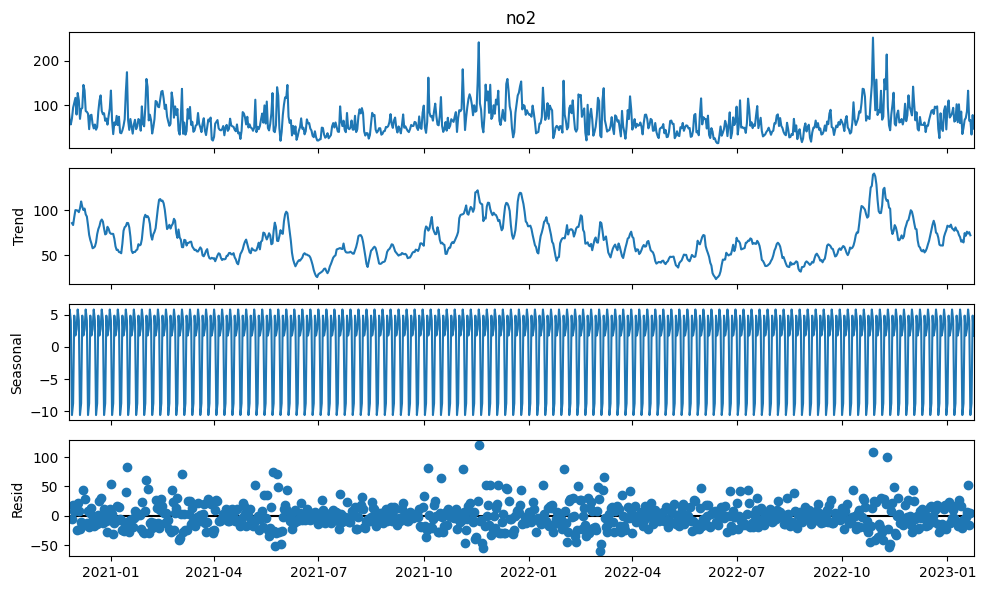

In [ ]:
pollutant = 'no2'

daily_data = data[pollutant].resample('D').mean()

daily_data = data[pollutant].resample('D').mean().interpolate()

# Fill remaining missing values
daily_data = daily_data.fillna(method='bfill')  # backfill
daily_data = daily_data.fillna(method='ffill')  # forward fill

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data)

# Plot the original data, the trend, the seasonality, and the residuals
rcParams['figure.figsize'] = 10, 6
fig = decomposition.plot()
plt.show()


Original Time Series (no2): The no2 levels fluctuate over time. This suggests variability in the no2 levels.

Trend: The trend component shows a smoother version of the observed data, highlighting general trends without short-term fluctuations.

Seasonality: The repeating patterns in the seasonal component indicate a seasonal pattern in the data. This suggests that there are repeating patterns in the no2 levels that occur at regular intervals.

Residuals: The residuals represent variations not explained by either trend or seasonality. The scattered points in the residual plot suggest that there might be other factors influencing the no2 levels that are not captured by the trend and seasonal components.

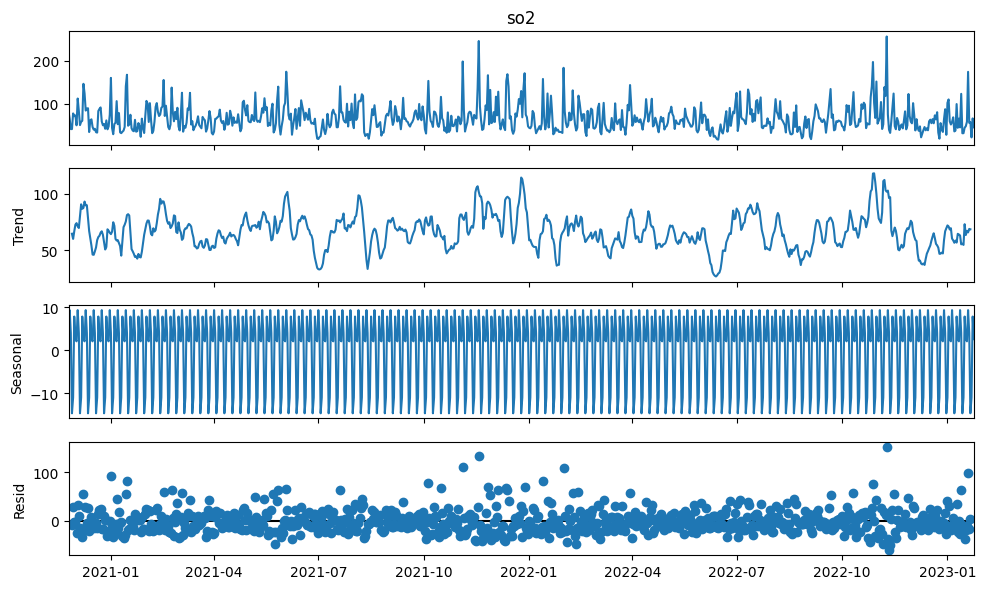

In [ ]:
pollutant = 'so2'

daily_data = data[pollutant].resample('D').mean()

daily_data = data[pollutant].resample('D').mean().interpolate()

# Fill remaining missing values
daily_data = daily_data.fillna(method='bfill')  # backfill
daily_data = daily_data.fillna(method='ffill')  # forward fill

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data)

# Plot the original data, the trend, the seasonality, and the residuals
rcParams['figure.figsize'] = 10, 6
fig = decomposition.plot()
plt.show()


Original Time Series (so2): The so2 levels fluctuate over time. This suggests variability in the so2 levels.

Trend: The trend component shows a smoother version of the observed data, highlighting general trends without short-term fluctuations.

Seasonality: The repeating patterns in the seasonal component indicate a seasonal pattern in the data. This suggests that there are repeating patterns in the so2 levels that occur at regular intervals.

Residuals: The residuals represent variations not explained by either trend or seasonality. The scattered points in the residual plot suggest that there might be other factors influencing the so2 levels that are not captured by the trend and seasonal components.

##observation summary for seasonality and trends:

PM10: The PM10 levels show variability with no clear upward or downward trend. There are repeating patterns suggesting seasonality in the data.

NH3: The NH3 levels also fluctuate over time. The trend component shows general trends without short-term fluctuations. The repeating patterns in the seasonal component suggest seasonality.

PM2.5: The PM2.5 levels fluctuate over time, suggesting variability. The trend component shows a smoother version of the observed data, highlighting general trends without short-term fluctuations. The repeating patterns in the seasonal component suggest seasonality.

CO: The CO levels fluctuate over time, suggesting variability. The trend component shows a smoother version of the observed data, highlighting general trends without short-term fluctuations. The repeating patterns in the seasonal component suggest seasonality.

NO: The NO levels fluctuate over time, suggesting variability. The trend component shows a smoother version of the observed data, highlighting general trends without short-term fluctuations. The repeating patterns in the seasonal component suggest seasonality.

NO2: The NO2 levels fluctuate over time, suggesting variability. The trend component shows a smoother version of the observed data, highlighting general trends without short-term fluctuations. The repeating patterns in the seasonal component suggest seasonality.

O3: The O3 levels fluctuate over time, suggesting variability. The trend component shows a smoother version of the observed data, highlighting general trends without short-term fluctuations. The repeating patterns in the seasonal component suggest seasonality.

SO2: The SO2 levels fluctuate over time, suggesting variability. The trend component shows a smoother version of the observed data, highlighting general trends without short-term fluctuations. The repeating patterns in the seasonal component suggest seasonality.

In [ ]:
sus  = data['pm10']
print(sus.info())
print(sus.head())

<class 'pandas.core.series.Series'>
DatetimeIndex: 18776 entries, 2020-11-25 01:00:00 to 2023-01-24 08:00:00
Series name: pm10
Non-Null Count  Dtype  
--------------  -----  
18776 non-null  float64
dtypes: float64(1)
memory usage: 809.4 KB
None
date
2020-11-25 01:00:00    411.73
2020-11-25 02:00:00    486.21
2020-11-25 03:00:00    541.95
2020-11-25 04:00:00    534.00
2020-11-25 05:00:00    529.19
Name: pm10, dtype: float64


###SARIMA model

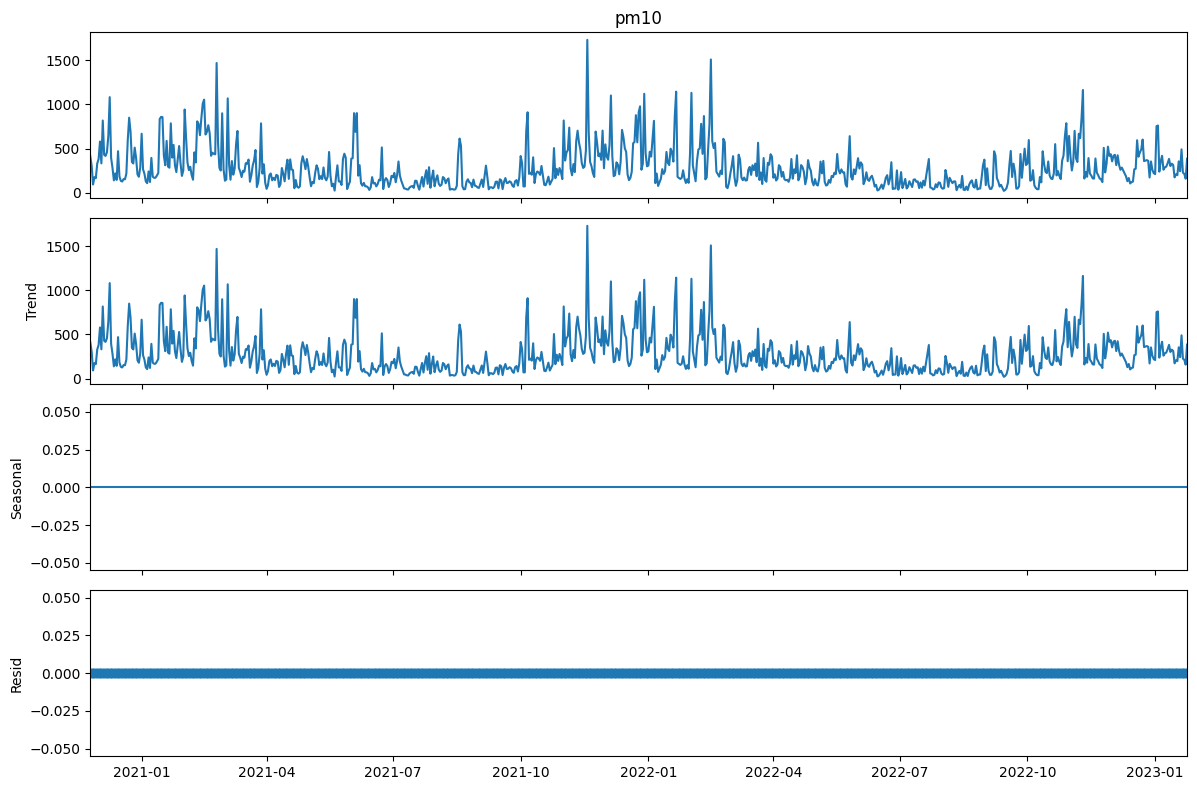

2023-01-25 01:00:00    298.378607
2023-01-26 01:00:00    303.356836
2023-01-27 01:00:00    336.240916
2023-01-28 01:00:00    329.836704
2023-01-29 01:00:00    366.302128
2023-01-30 01:00:00    297.842936
2023-01-31 01:00:00    276.669882
2023-02-01 01:00:00    261.560938
2023-02-02 01:00:00    315.843657
2023-02-03 01:00:00    296.697617
2023-02-04 01:00:00    315.071162
Freq: D, Name: predicted_mean, dtype: float64


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt


data = data.asfreq('D')

attribute = 'pm10'

# Resample your data to daily frequency and interpolate missing values
daily_data = data[attribute].resample('D').mean().interpolate()

# Fill remaining missing values
daily_data = daily_data.fillna(method='bfill')  # backfill
daily_data = daily_data.fillna(method='ffill')  # forward fill

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data, period=1)

# Plot the original data, the trend, the seasonality, and the residuals
rcParams['figure.figsize'] = 12, 8
fig = decomposition.plot()
plt.show()

# Determine the parameters for the SARIMA model
p = 1
d = 1
q = 1
P = 1
D = 1
Q = 1
s = 12

# Build and fit the model
model = SARIMAX(data[attribute], order=(p,d,q), seasonal_order=(P,D,Q,s))
model_fit = model.fit(disp=False)

# Make prediction
forecast = model_fit.predict(len(data), len(data)+10)
print(forecast)


###forecasting

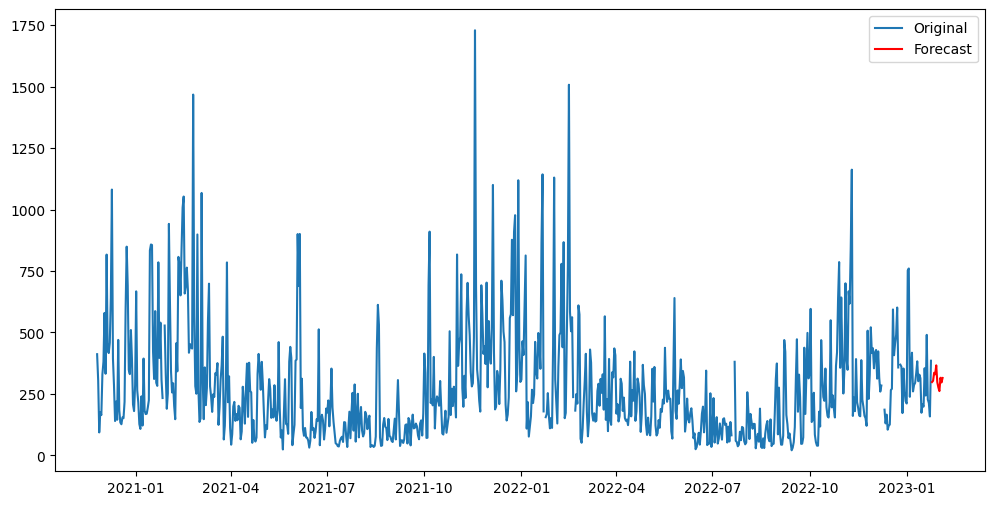

In [ ]:
# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(data[attribute], label='Original')

# Plot forecasted results
plt.plot(forecast, color='red', label='Forecast')

plt.legend()
plt.show()


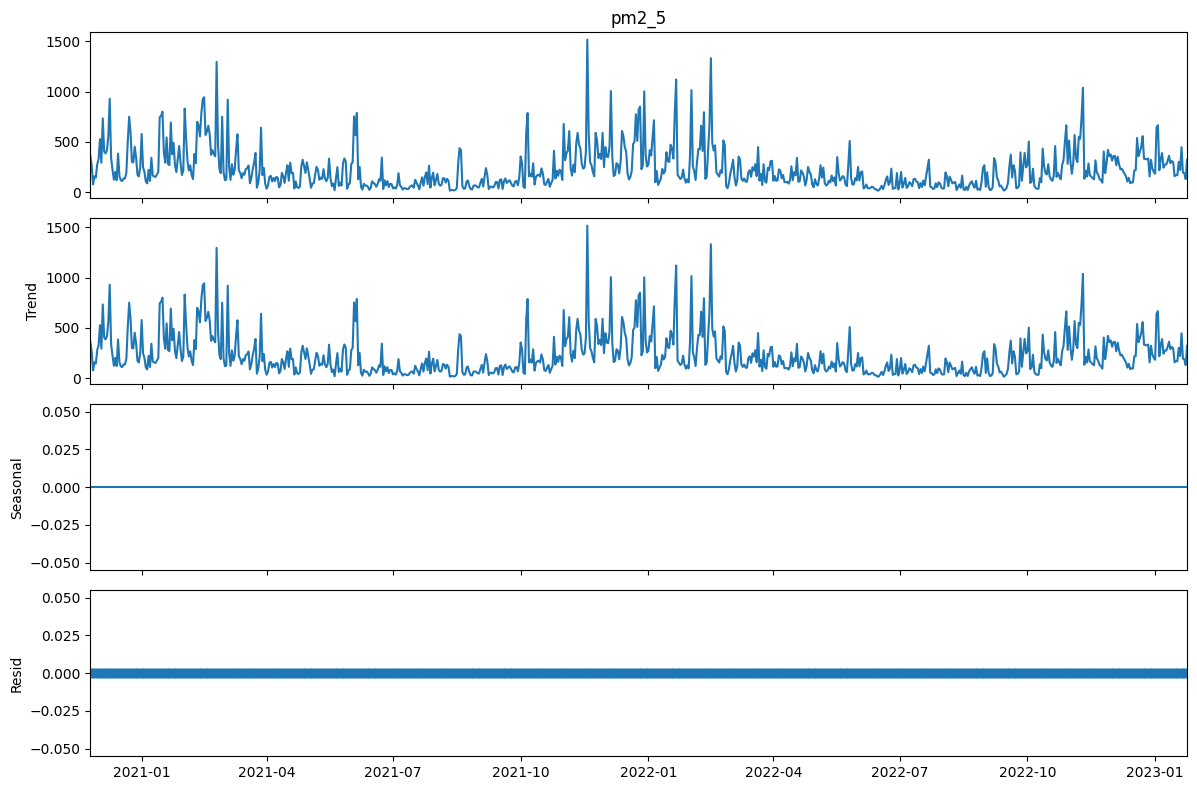

2023-01-25 01:00:00    216.808274
2023-01-26 01:00:00    227.149430
2023-01-27 01:00:00    258.482049
2023-01-28 01:00:00    245.079336
2023-01-29 01:00:00    264.504795
2023-01-30 01:00:00    230.375568
2023-01-31 01:00:00    203.040913
2023-02-01 01:00:00    198.877063
2023-02-02 01:00:00    233.866650
2023-02-03 01:00:00    204.552673
2023-02-04 01:00:00    211.046451
Freq: D, Name: predicted_mean, dtype: float64


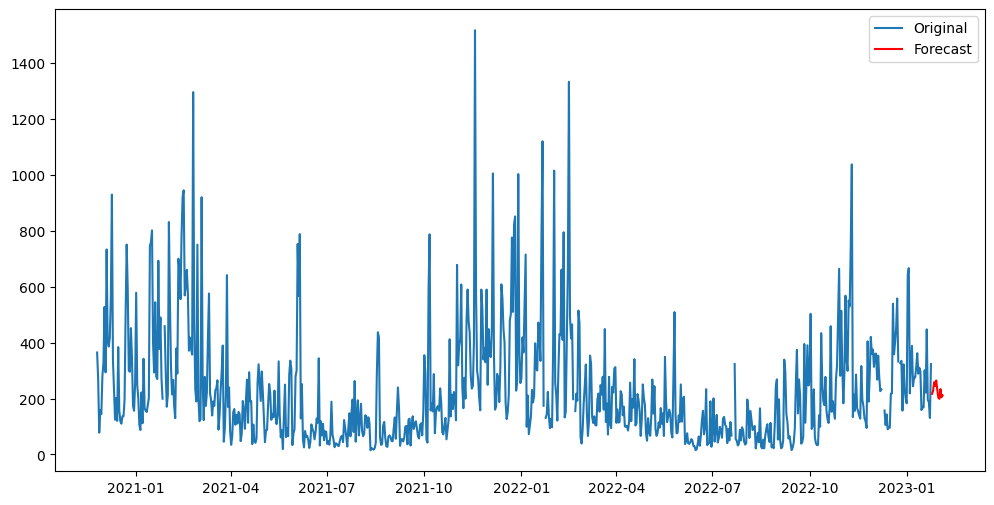

In [14]:
data = data.asfreq('D')

attribute = 'pm2_5'

# Resample your data to daily frequency and interpolate missing values
daily_data = data[attribute].resample('D').mean().interpolate()

# Fill remaining missing values
daily_data = daily_data.fillna(method='bfill')  # backfill
daily_data = daily_data.fillna(method='ffill')  # forward fill

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data, period=1)

# Plot the original data, the trend, the seasonality, and the residuals
rcParams['figure.figsize'] = 12, 8
fig = decomposition.plot()
plt.show()

# Determine the parameters for the SARIMA model
p = 1
d = 0
q = 1
P = 1
D = 1
Q = 1
s = 12

# Build and fit the model
model = SARIMAX(data[attribute], order=(p,d,q), seasonal_order=(P,D,Q,s))
model_fit = model.fit(disp=False)

# Make prediction
forecast = model_fit.predict(len(data), len(data)+10)
print(forecast)


# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(data[attribute], label='Original')

# Plot forecasted results
plt.plot(forecast, color='red', label='Forecast')

plt.legend()
plt.show()


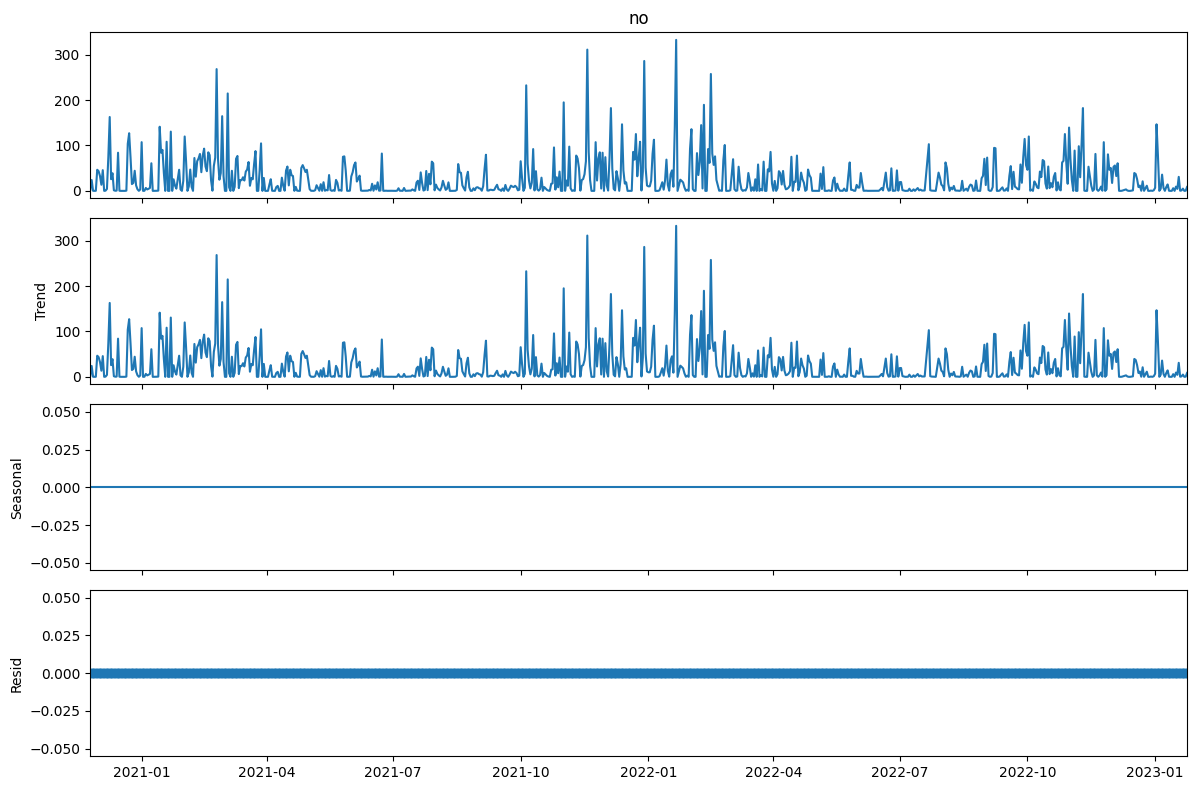

2023-01-25 01:00:00     4.910407
2023-01-26 01:00:00     4.225589
2023-01-27 01:00:00    14.595780
2023-01-28 01:00:00    17.322013
2023-01-29 01:00:00    21.952406
2023-01-30 01:00:00    12.583208
2023-01-31 01:00:00     7.516083
2023-02-01 01:00:00     7.480025
2023-02-02 01:00:00    15.537500
2023-02-03 01:00:00    10.272402
2023-02-04 01:00:00    10.162548
2023-02-05 01:00:00    20.530146
2023-02-06 01:00:00     5.926433
2023-02-07 01:00:00     4.403595
2023-02-08 01:00:00    12.737219
2023-02-09 01:00:00    16.179780
2023-02-10 01:00:00    19.728226
2023-02-11 01:00:00    14.374491
2023-02-12 01:00:00     6.449359
2023-02-13 01:00:00     6.494719
2023-02-14 01:00:00    14.089292
Freq: D, Name: predicted_mean, dtype: float64


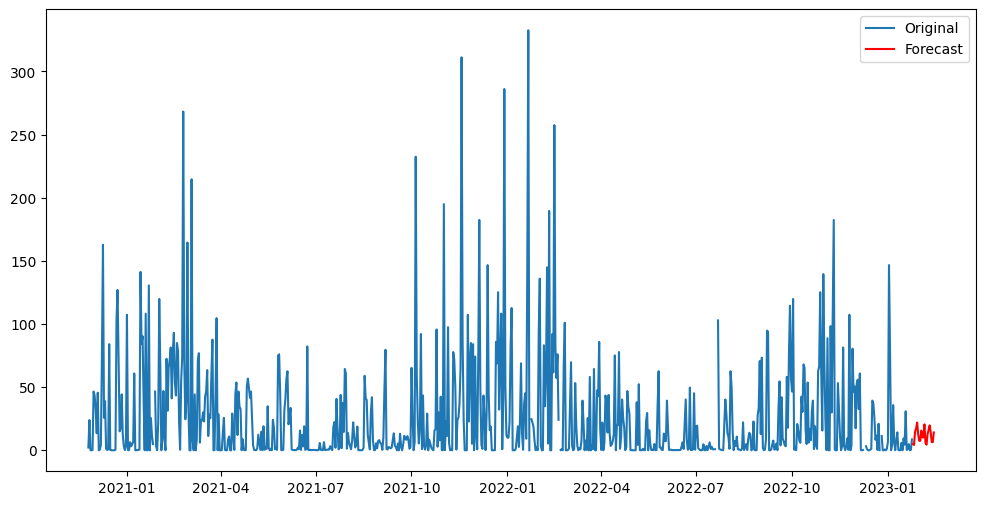

In [10]:

data = data.asfreq('D')

attribute = 'no'

# Resample your data to daily frequency and interpolate missing values
daily_data = data[attribute].resample('D').mean().interpolate()

# Fill remaining missing values
daily_data = daily_data.fillna(method='bfill')  # backfill
daily_data = daily_data.fillna(method='ffill')  # forward fill

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data, period=1)

# Plot the original data, the trend, the seasonality, and the residuals
rcParams['figure.figsize'] = 12, 8
fig = decomposition.plot()
plt.show()

# Determine the parameters for the SARIMA model
p = 1
d = 1
q = 1
P = 1
D = 1
Q = 1
s = 12

# Build and fit the model
model = SARIMAX(data[attribute], order=(p,d,q), seasonal_order=(P,D,Q,s))
model_fit = model.fit(disp=False)

# Make prediction
forecast = model_fit.predict(len(data), len(data)+20)
print(forecast)


# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(data[attribute], label='Original')

# Plot forecasted results
plt.plot(forecast, color='red', label='Forecast')

plt.legend()
plt.show()


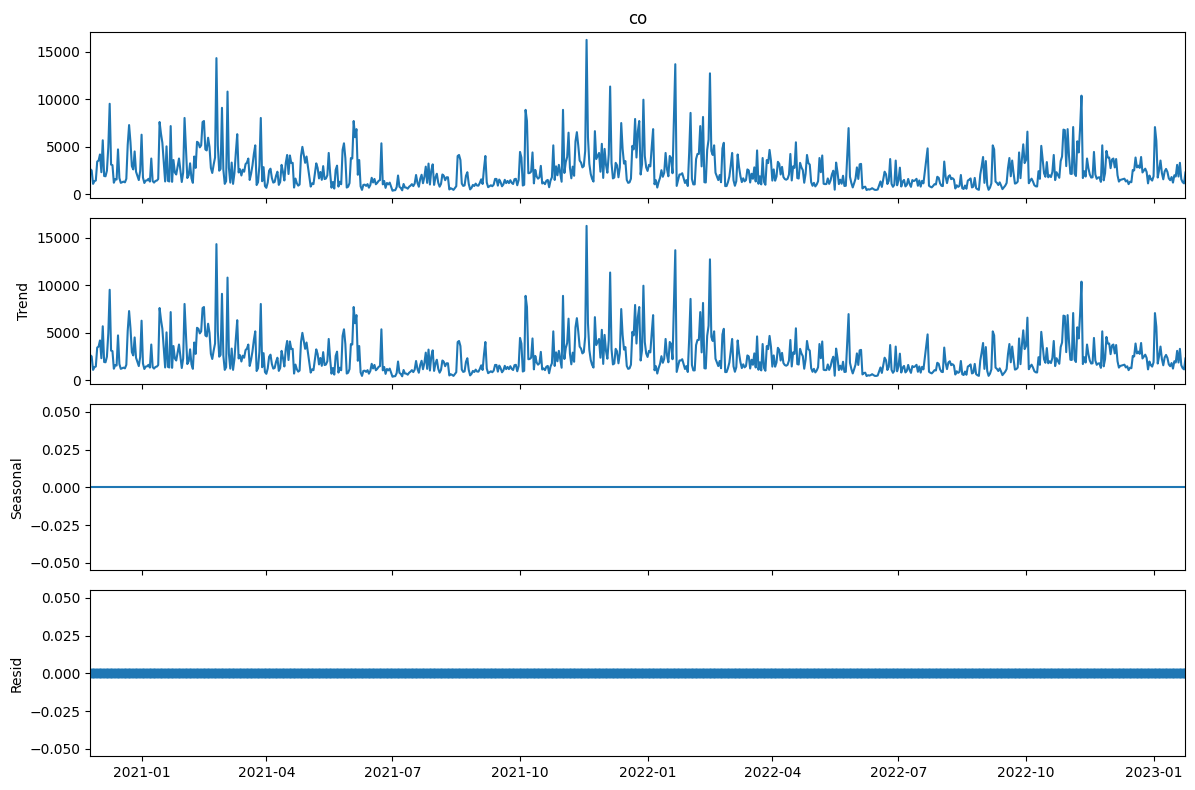

2023-01-25 01:00:00    1929.992414
2023-01-26 01:00:00    2014.220577
2023-01-27 01:00:00    2383.533308
2023-01-28 01:00:00    2383.619370
2023-01-29 01:00:00    2670.364771
2023-01-30 01:00:00    2151.880890
2023-01-31 01:00:00    1954.713708
2023-02-01 01:00:00    1855.567723
2023-02-02 01:00:00    2352.258870
2023-02-03 01:00:00    2173.898497
2023-02-04 01:00:00    2182.249028
2023-02-05 01:00:00    2662.919600
2023-02-06 01:00:00    1989.221099
2023-02-07 01:00:00    2012.996563
2023-02-08 01:00:00    2260.168459
2023-02-09 01:00:00    2336.396508
2023-02-10 01:00:00    2577.609022
2023-02-11 01:00:00    2242.579677
2023-02-12 01:00:00    1936.843691
2023-02-13 01:00:00    1999.815294
2023-02-14 01:00:00    2263.039823
Freq: D, Name: predicted_mean, dtype: float64


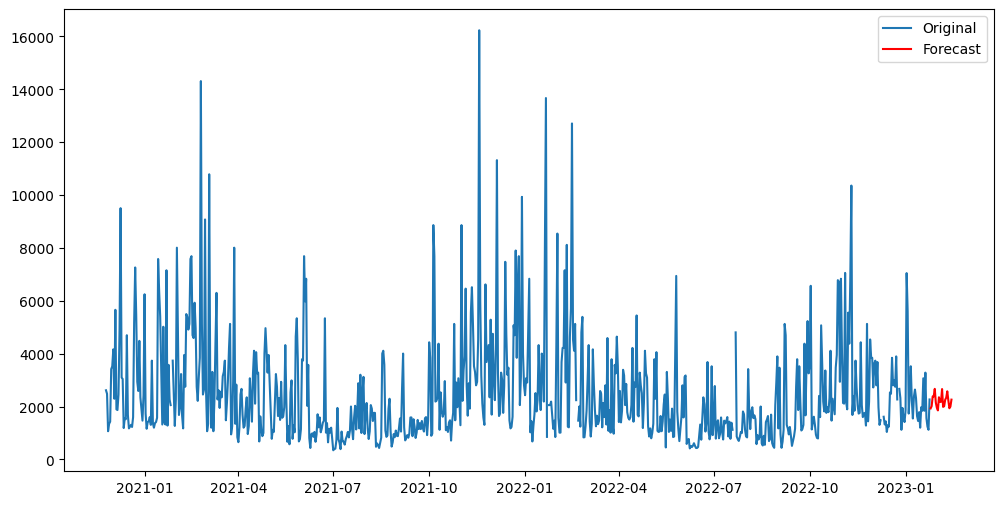

In [11]:

data = data.asfreq('D')

attribute = 'co'

# Resample your data to daily frequency and interpolate missing values
daily_data = data[attribute].resample('D').mean().interpolate()

# Fill remaining missing values
daily_data = daily_data.fillna(method='bfill')  # backfill
daily_data = daily_data.fillna(method='ffill')  # forward fill

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data, period=1)

# Plot the original data, the trend, the seasonality, and the residuals
rcParams['figure.figsize'] = 12, 8
fig = decomposition.plot()
plt.show()

# Determine the parameters for the SARIMA model
p = 1
d = 1
q = 1
P = 1
D = 1
Q = 1
s = 12

# Build and fit the model
model = SARIMAX(data[attribute], order=(p,d,q), seasonal_order=(P,D,Q,s))
model_fit = model.fit(disp=False)

# Make prediction
forecast = model_fit.predict(len(data), len(data)+20)
print(forecast)


# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(data[attribute], label='Original')

# Plot forecasted results
plt.plot(forecast, color='red', label='Forecast')

plt.legend()
plt.show()


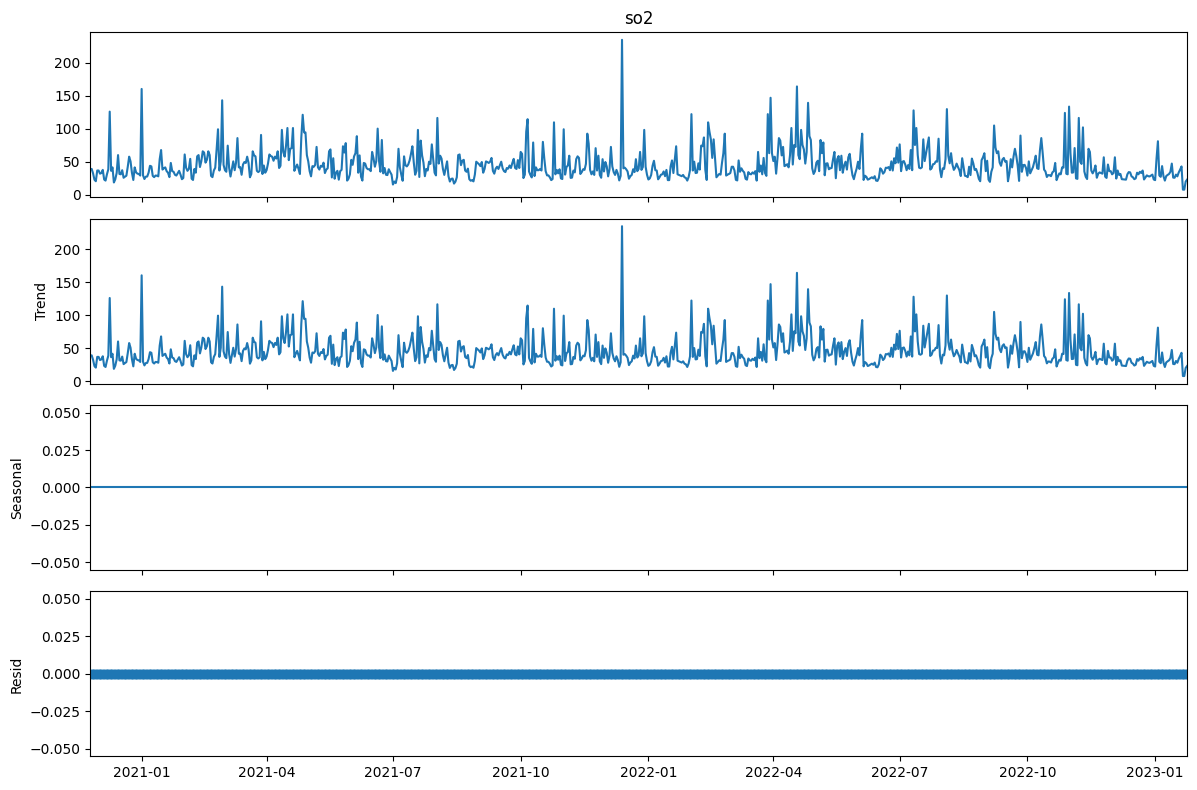

2023-01-25 01:00:00    29.883498
2023-01-26 01:00:00    26.744938
2023-01-27 01:00:00    32.836656
2023-01-28 01:00:00    28.807101
2023-01-29 01:00:00    31.213024
2023-01-30 01:00:00    28.755170
2023-01-31 01:00:00    29.391998
2023-02-01 01:00:00    27.166461
2023-02-02 01:00:00    26.283325
2023-02-03 01:00:00    28.266006
2023-02-04 01:00:00    25.920489
2023-02-05 01:00:00    33.572204
2023-02-06 01:00:00    31.767111
2023-02-07 01:00:00    26.824853
2023-02-08 01:00:00    32.552413
2023-02-09 01:00:00    28.728916
2023-02-10 01:00:00    30.996157
2023-02-11 01:00:00    28.762636
2023-02-12 01:00:00    29.496886
2023-02-13 01:00:00    27.458064
2023-02-14 01:00:00    25.659715
Freq: D, Name: predicted_mean, dtype: float64


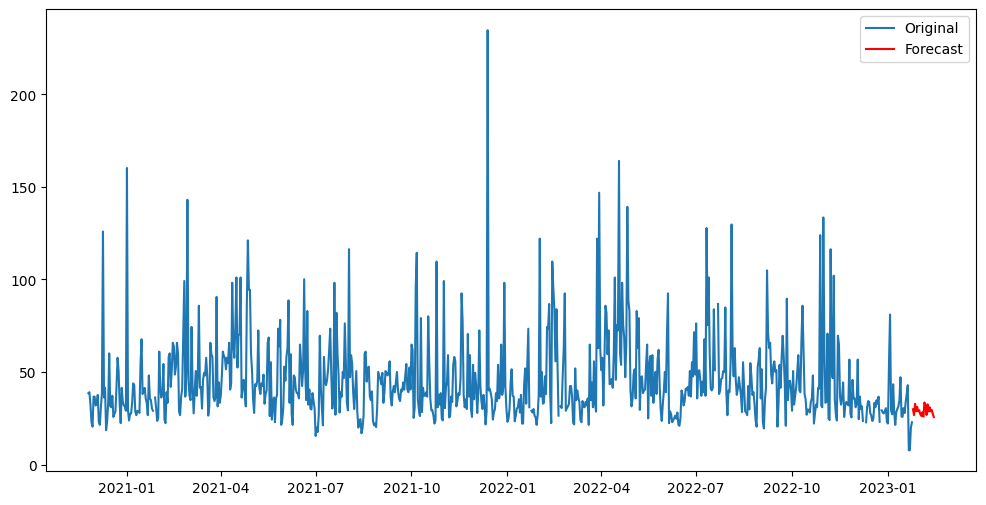

In [12]:

data = data.asfreq('D')

attribute = 'so2'

# Resample your data to daily frequency and interpolate missing values
daily_data = data[attribute].resample('D').mean().interpolate()

# Fill remaining missing values
daily_data = daily_data.fillna(method='bfill')  # backfill
daily_data = daily_data.fillna(method='ffill')  # forward fill

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data, period=1)

# Plot the original data, the trend, the seasonality, and the residuals
rcParams['figure.figsize'] = 12, 8
fig = decomposition.plot()
plt.show()

# Determine the parameters for the SARIMA model
p = 1
d = 1
q = 1
P = 1
D = 1
Q = 1
s = 12

# Build and fit the model
model = SARIMAX(data[attribute], order=(p,d,q), seasonal_order=(P,D,Q,s))
model_fit = model.fit(disp=False)

# Make prediction
forecast = model_fit.predict(len(data), len(data)+20)
print(forecast)


# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(data[attribute], label='Original')

# Plot forecasted results
plt.plot(forecast, color='red', label='Forecast')

plt.legend()
plt.show()


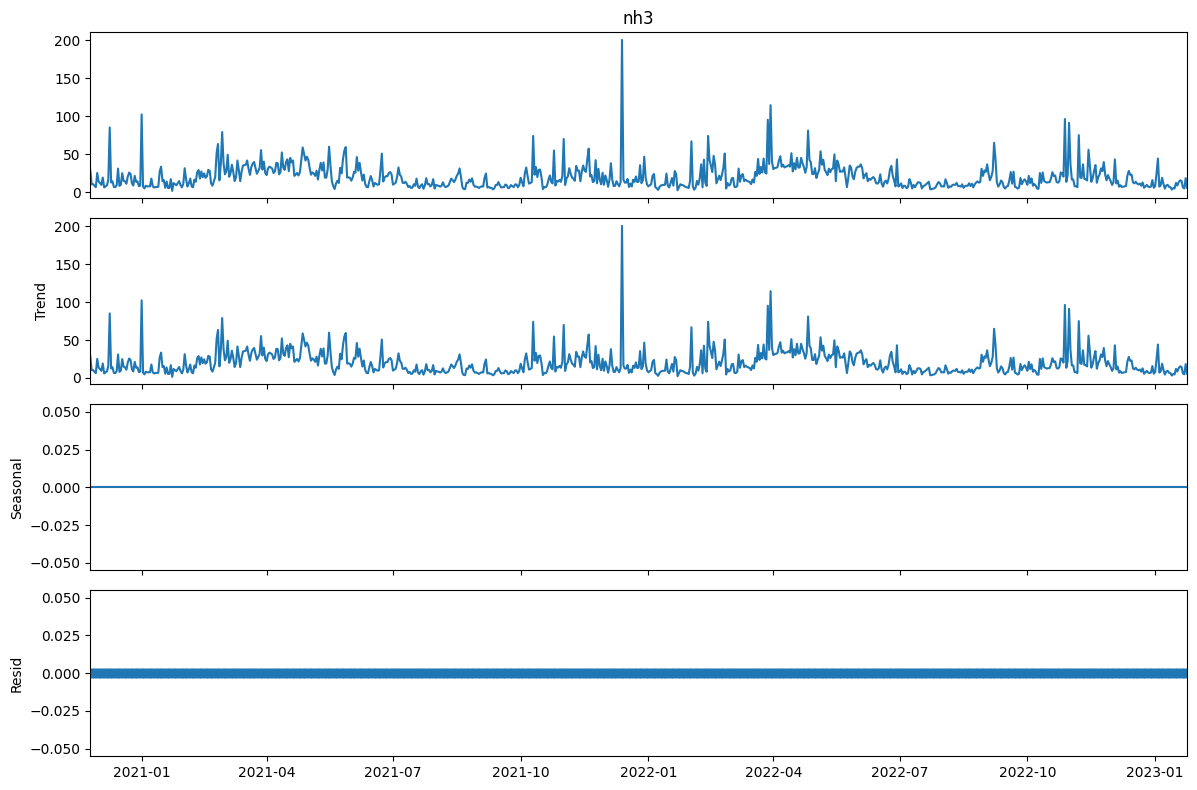

2023-01-25 01:00:00    15.549511
2023-01-26 01:00:00    16.817720
2023-01-27 01:00:00    19.480953
2023-01-28 01:00:00    18.743961
2023-01-29 01:00:00    18.348629
2023-01-30 01:00:00    18.308975
2023-01-31 01:00:00    18.239538
2023-02-01 01:00:00    17.869991
2023-02-02 01:00:00    15.564258
2023-02-03 01:00:00    16.677482
2023-02-04 01:00:00    18.877794
2023-02-05 01:00:00    18.611447
2023-02-06 01:00:00    21.185621
2023-02-07 01:00:00    18.879795
2023-02-08 01:00:00    22.090535
2023-02-09 01:00:00    19.928511
2023-02-10 01:00:00    20.087996
2023-02-11 01:00:00    19.236820
2023-02-12 01:00:00    18.752871
2023-02-13 01:00:00    18.452212
2023-02-14 01:00:00    17.248161
Freq: D, Name: predicted_mean, dtype: float64


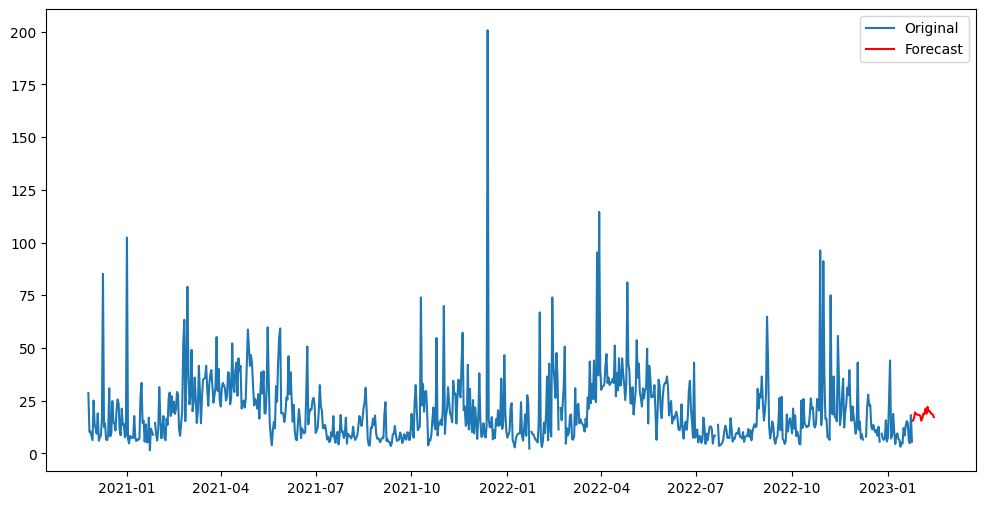

In [13]:

data = data.asfreq('D')

attribute = 'nh3'

# Resample your data to daily frequency and interpolate missing values
daily_data = data[attribute].resample('D').mean().interpolate()

# Fill remaining missing values
daily_data = daily_data.fillna(method='bfill')  # backfill
daily_data = daily_data.fillna(method='ffill')  # forward fill

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data, period=1)

# Plot the original data, the trend, the seasonality, and the residuals
rcParams['figure.figsize'] = 12, 8
fig = decomposition.plot()
plt.show()

# Determine the parameters for the SARIMA model
p = 0
d = 0
q = 1
P = 1
D = 1
Q = 1
s = 12

# Build and fit the model
model = SARIMAX(data[attribute], order=(p,d,q), seasonal_order=(P,D,Q,s))
model_fit = model.fit(disp=False)

# Make prediction
forecast = model_fit.predict(len(data), len(data)+20)
print(forecast)


# Plot original data
plt.figure(figsize=(12, 6))
plt.plot(data[attribute], label='Original')

# Plot forecasted results
plt.plot(forecast, color='red', label='Forecast')

plt.legend()
plt.show()
